Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- uses OSMNx, pandas, geopandas, rasterio
- may include content from ChatGPT or GitHub Copilot

### Features
- [X] Calculate population statistics
- [X] Built area percentage
- [X] Replicate the model suitability calculation
- [X] Replicate the agents' utility function calculation
- [ ] Calculate vegetation cover based on NDVI
- [ ] Calculate economic inequality - how? using 1km income data?
- [ ] calculate informal settlement extent and population

# Imports

In [1]:
import pandas as pd
import geopandas as gpd

import os
from pathlib import Path
import fnmatch
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from shapely.geometry.polygon import Polygon
from shapely.geometry import MultiLineString, LineString
import json

import rasterio
from rasterio import features
from rasterio.warp import reproject, calculate_default_transform, Resampling
from rasterio.mask import mask
from rasterio.plot import show, show_hist, plotting_extent
from scipy.ndimage import distance_transform_edt, gaussian_filter
from skimage.graph import route_through_array

import ee
import geemap
import logging

from osgeo import gdal, osr 
import tempfile

import random 

#from rasterstats import zonal_stats

import osmnx as ox

# init

In [ ]:
#input a vector and a raster file for each city
AOI_path = Path('../data/processed/')
MUM_file = 'MUM_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.08.2024
MAN_file = 'MAN_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.11.2024
JAK_file = 'JAK_LIM_reference_AOI_30m.shp' # APS: updated AOI 23.08.2024
#  the 'case_city' variable defines the city we are working on. APS: Need to update the code below to change it from MUM to the variable name

case_city = 'MAN' #MUM MAN JAK

if case_city == 'MUM':
    
    AOI_gdf = gpd.read_file(AOI_path / MUM_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MUM_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/MUM_LIM_reference_AOI_150m.tif')
    

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/MUM/data/in/')
    ti_city_out_path = Path('../model/MUM/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_3'

if case_city == 'MAN':
    
    AOI_gdf = gpd.read_file(AOI_path / MAN_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MAN_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/MAN_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/MAN/data/in/')
    ti_city_out_path = Path('../model/MAN/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_2'

if case_city == 'JAK':
    
    AOI_gdf = gpd.read_file(AOI_path / JAK_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/JAK_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/JAK_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/JAK/data/in/')
    ti_city_out_path = Path('../model/JAK/data/out/')
    ref_raster_sleuth_path = model_inputs_SLEUTH_150m_path / (case_city + '_URB_SLEUTH_input_2022.tif' )

    gadm_var = 'NAME_2'

external_data_path = Path(r'D:\\Dropbox\\x\\_data')
ascii150_arcgis_path = Path(r"D:\\Dropbox\\x\\PostDoc\ASCII_150m")

%run ./ti_city_00_raster_functions.ipynb

# read the reference raster
with rasterio.open(ref_raster_path,'r') as src:
    ref_raster = src
    ref_meta = src.meta
    ref_height, ref_width, ref_area = get_transform(ref_raster)



# suppress deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# 1. Population from the WD POP rasters

In [5]:
img_name_2000 = case_city + '_POP_population_2000_WDPop_90m.tif'
img_name_2015 = case_city + '_POP_population_2015_WDPop_90m.tif'

# load population raster files 
with rasterio.open(interim_path / img_name_2000,'r') as pop_raster_2000:
    pop_2000_array = pop_raster_2000.read(1)
    
with rasterio.open(interim_path / img_name_2015,'r') as pop_raster_2015:
    pop_2015_array = pop_raster_2015.read(1)
    # calculate the area of the pixels in the rasters using the afine information
        
pop_stack = np.stack([pop_2000_array, pop_2015_array], axis=0)
print(len(pop_stack), pop_stack.shape)

2 (2, 1762, 1383)


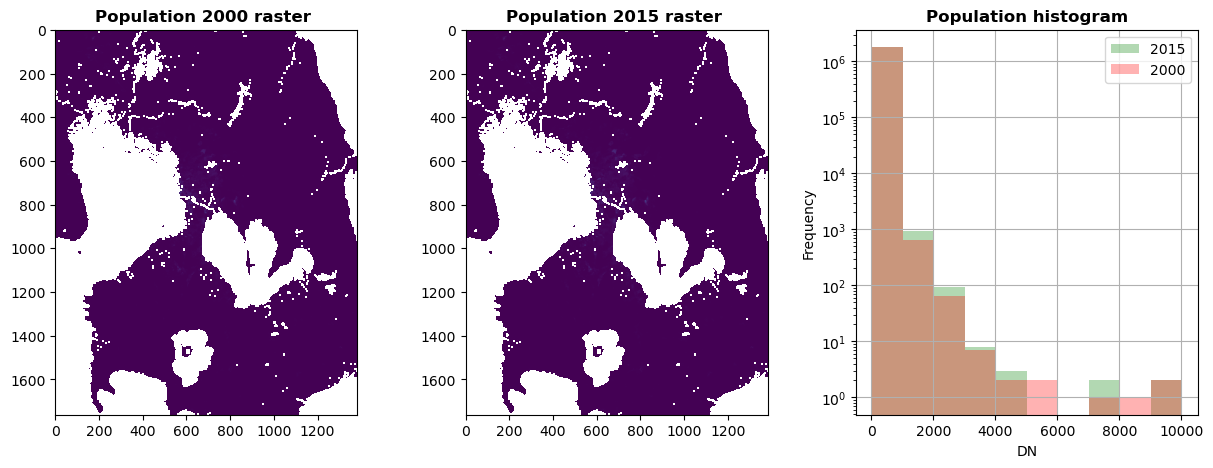

In [6]:
def raster_plot_hist(raster, titles, bins=100):
    unique_values = len(raster)
    bands_list = []
    for i in range(unique_values):
        bands_list.append('band' + str(i))
    fig, ax = plt.subplots(nrows=1, ncols=unique_values+1, figsize=(15, 5))
    for i in range(len(bands_list)):
        bands_list[i] = raster[i]
        show(bands_list[i], ax=ax[i], title=titles[i] + " raster ")
    
    labels = []
    for i in range(len(titles)):
        labels.append(titles[i].split(' ')[1])
    show_hist(raster, ax=ax[unique_values],bins=bins, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title=titles[0].split(' ')[0] + " histogram", log=True, label=labels)
    plt.show()

raster_plot_hist(pop_stack, ['Population 2000', 'Population 2015'], 10)

In [ ]:
def raster_area_by_values_greater(raster, values, transform=None):
    if type(raster) == np.ndarray:
        array = raster
        transform = transform if transform else ref_raster.transform
    else:
        array = raster.read(1)
        transform = raster.transform

    cell_width = transform[0]
    cell_height = -transform[4]
    #print(f'Cell width: {cell_width}, Cell height: {cell_height}')
    area = round(np.sum(array >= values)*cell_width*cell_height, 4)
    print(f'Area with value greater than {values}: {area}')

    return area
    
def raster_area_by_values_smaller(raster, values, transform=None):
    if type(raster) == np.ndarray:
        array = raster
        transform = transform if transform else ref_raster.transform
    else:
        array = raster.read(1)
        transform = raster.transform

    cell_width = transform[0]
    cell_height = -transform[4]
    #print(f'Cell width: {cell_width}, Cell height: {cell_height}')
    area = round(np.sum(array < values)*cell_width*cell_height, 4)
    print(f'Area with value smaller than {values}: {area}')

    return area

def raster_area_by_values_list(raster, values, transform=None):
    if type(raster) == np.ndarray:
        array = raster
        transform = transform if transform else ref_raster.transform
    else:
        array = raster.read(1)
        transform = raster.transform

    cell_width = transform[0]
    cell_height = -transform[4]
    #print(f'Cell width: {cell_width}, Cell height: {cell_height}')
    area_list = []
    for value in values:
        area = round(np.sum(array == value)*cell_width*cell_height,4)
        area_list.append(area)
        print(f'Area for value {value}: {area}')

    return area_list

In [11]:
pop_2000 = pop_stack[0]
pop_2015 = pop_stack[1]

pop_2000_sum = np.nansum(pop_2000)
pop_2015_sum = np.nansum(pop_2015)

builtup_1985_file = case_city + '_URB_urbanisation_1985_EOC_WUF_30m.tif'
builtup_2000_file = case_city + '_URB_urbanisation_2000_EOC_WUF_30m.tif'
builtup_2015_file = case_city + '_URB_urbanisation_2015_EOC_WUF_30m.tif'

print(builtup_1985_file, '\n', builtup_2000_file, '\n', builtup_2015_file)
with rasterio.open(interim_path / builtup_1985_file) as bu1985:
    area_1985_sum = np.nansum(bu1985.read(1) == 1,  dtype=np.int64) * 900

with rasterio.open(interim_path / builtup_2000_file) as bu2000:
    area_2000_sum = np.nansum(bu2000.read(1) == 1,  dtype=np.int64) * 900

with rasterio.open(interim_path / builtup_2015_file) as bu2015:
    area_2015_sum = np.nansum(bu2015.read(1) == 1,  dtype=np.int64) * 900

case_pop_stats_df = pd.DataFrame({'1985':[0,area_1985_sum],'2000': [pop_2000_sum, area_2000_sum], '2015': [pop_2015_sum, area_2015_sum]})
case_pop_stats_df

MAN_URB_urbanisation_1985_EOC_WUF_30m.tif 
 MAN_URB_urbanisation_2000_EOC_WUF_30m.tif 
 MAN_URB_urbanisation_2015_EOC_WUF_30m.tif


1985          2000          2015
0           0  2.445847e+07  3.069841e+07
1  1222611300  1.815512e+09  2.248410e+09

## Population per district

In [12]:
if type(gadm_gdf) == gpd.geodataframe.GeoDataFrame:
    district_gdf = gadm_gdf.loc[:,['GID_3','NAME_3','geometry']]
    print(district_gdf.crs, district_gdf.shape)
else:
    # import the GADM4 level 3 polygons from the shapefile
    gadm_file_name = case_city + '_LIM_admin_boundaries_Maharastra_GADM_A.shp'

    gadm_path = external_path / gadm_file_name
    gadm_gdf_temp = gpd.read_file(gadm_path)

    # clip the vectors to the AOI 
    gadm_gdf = gadm_gdf_temp.clip(AOI_gdf, keep_geom_type=True)

    # convert 'NAME_3' to a sequential number
    gadm_gdf['NAME_3'] = gadm_gdf['NAME_3'].astype('category')
    gadm_gdf['NAME_3_num'] = gadm_gdf['NAME_3'].cat.codes
    print('The max was', gadm_gdf['NAME_3_num'].max())
    gadm_gdf.loc[gadm_gdf.NAME_3_num == 0, 'NAME_3_num'] = 32

    print('The max is now', gadm_gdf['NAME_3_num'].max(),
        '. The values are\n',gadm_gdf['NAME_3_num'].sort_values().unique())


NameError: name 'gadm_gdf' is not defined

In [ ]:


def zonal_stats_df(df, raster_path, stats_list=None, transform=None):    
    with rasterio.open(raster_path) as raster:
        transform = raster.transform
        stats = zonal_stats(df, raster_path, affine=transform, stats=stats_list)
        updated_df = df.reset_index()
        for i, stat in enumerate(stats_list):
            updated_df[stat] = [x[stat] for x in stats]
        
    return  updated_df 

def districts_stats(df, raster_path, id=None, title=None, stats_list=None):
    if id:
        id = id
    else:
        id = 'new_id'
    cols = []
    cols.append(id)
    cols = cols+stats_list
    print(cols)
    updated_df = zonal_stats_df(df, raster_path, stats_list)
    #merged_gdf = updated_df
    merged_gdf = pd.merge(left=df, right=updated_df.loc[:,cols], how='left', left_on=id, right_on=id)
    for i in range(len(stats_list)):
        merged_gdf = merged_gdf.rename(columns={stats_list[i]: title + '_' + stats_list[i]})
    return merged_gdf


In [55]:
case_pop_2000_path = case_city + '_POP_population_2000_WDPop_WGS_90m.tif'
case_pop_2015_path = case_city + '_POP_population_2015_WDPop_WGS_90m.tif'

pop_2000_path = interim_path / case_pop_2000_path
pop_2015_path = interim_path / case_pop_2015_path

#df = districts_stats(district_gdf, pop_2000_path, id='GID_3', title='pop_2000_', stats_list=stats_list)
raster_dict = {'pop_2000': pop_2000_path, 'pop_2015': pop_2015_path}
stats_list = ['sum', 'count', 'mean', 'std']
pop_gdf = district_gdf

for value, key in raster_dict.items():
    pop_gdf = districts_stats(df = pop_gdf, 
                         raster_path = key, 
                         id='GID_3', 
                         title = value, 
                         stats_list=stats_list)
pop_gdf.head()

['GID_3', 'sum', 'count', 'mean', 'std']
['GID_3', 'sum', 'count', 'mean', 'std']


GID_3        NAME_3  \
0   IND.20.26.8_1          Paud   
1   IND.20.27.4_1       Mangaon   
2  IND.20.27.13_1  n.a. ( 1634)   
3  IND.20.27.20_1          Roha   
4  IND.20.27.17_1          Pali   

                                            geometry  pop_2000_sum  \
0  POLYGON ((332850.985 2042536.733, 332731.242 2...  19048.052734   
1  POLYGON ((327980.174 2042051.986, 328399.497 2...   1041.146484   
2  POLYGON ((281340.769 2050047.501, 282151.287 2...  20839.917969   
3  POLYGON ((289747.934 2045099.454, 289739.181 2...  57968.789062   
4  POLYGON ((330898.415 2064863.731, 331090.146 2...  44566.796875   

   pop_2000_count  pop_2000_mean  pop_2000_std  pop_2015_sum  pop_2015_count  \
0           29729       0.640723      0.567663  16167.771484           29729   
1            1213       0.858324      0.542913    820.291016            1213   
2            9017       2.311181      1.570293  27507.089844            9017   
3           30592       1.894900      1.605643  74533.765625           30592   
4           53881       0.827134      0.585420  61065.492188           53881   

   pop_2015_mean  pop_2015_std  
0       0.543838      0.435348  
1       0.676250      0.691117  
2       3.050581      3.065823  
3       2.436381      2.731232  
4       1.133340      0.993074

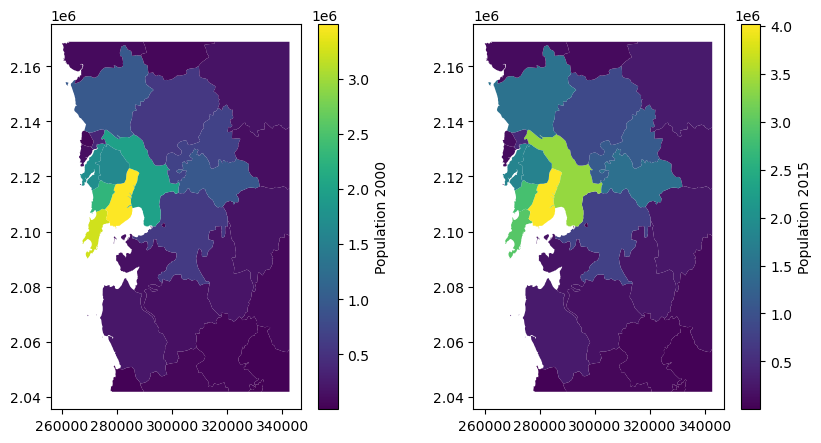

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

pop_gdf.plot(column='pop_2000_sum', legend=True, ax=ax[0], cmap='viridis', legend_kwds={'label': "Population 2000", 'orientation': "vertical"})
pop_gdf.plot(column='pop_2015_sum', legend=True, ax=ax[1], cmap='viridis', legend_kwds={'label': "Population 2015", 'orientation': "vertical"})

plt.show()

# 2. Built area percentage per district

In [57]:
case_urban_2000_file = case_city + '_URB_urbanisation_2000_EOC_WUF_temp_30m.tif'
case_urban_2015_file = case_city + '_URB_urbanisation_2015_EOC_WUF_temp_30m.tif'

bu_2000_path = interim_path / case_urban_2000_file
bu_2015_path = interim_path / case_urban_2015_file

stats_list = ['count']
raster_dict = {'bu_2000': bu_2000_path, 'bu_2015': bu_2015_path}

bu_pop_gdf = pop_gdf

for value, key in raster_dict.items():
    bu_pop_gdf = districts_stats(df = bu_pop_gdf, 
                         raster_path = key, 
                         id='GID_3', 
                         title = value, 
                         stats_list=stats_list)

bu_pop_gdf.head()


['GID_3', 'count']
['GID_3', 'count']


GID_3        NAME_3  \
0   IND.20.26.8_1          Paud   
1   IND.20.27.4_1       Mangaon   
2  IND.20.27.13_1  n.a. ( 1634)   
3  IND.20.27.20_1          Roha   
4  IND.20.27.17_1          Pali   

                                            geometry  pop_2000_sum  \
0  POLYGON ((332850.985 2042536.733, 332731.242 2...  19048.052734   
1  POLYGON ((327980.174 2042051.986, 328399.497 2...   1041.146484   
2  POLYGON ((281340.769 2050047.501, 282151.287 2...  20839.917969   
3  POLYGON ((289747.934 2045099.454, 289739.181 2...  57968.789062   
4  POLYGON ((330898.415 2064863.731, 331090.146 2...  44566.796875   

   pop_2000_count  pop_2000_mean  pop_2000_std  pop_2015_sum  pop_2015_count  \
0           29729       0.640723      0.567663  16167.771484           29729   
1            1213       0.858324      0.542913    820.291016            1213   
2            9017       2.311181      1.570293  27507.089844            9017   
3           30592       1.894900      1.605643  74533.765625           30592   
4           53881       0.827134      0.585420  61065.492188           53881   

   pop_2015_mean  pop_2015_std  bu_2000_count  bu_2015_count  
0       0.543838      0.435348            495           2454  
1       0.676250      0.691117              9             11  
2       3.050581      3.065823           1304           1665  
3       2.436381      2.731232           3713           4802  
4       1.133340      0.993074           2468           3743

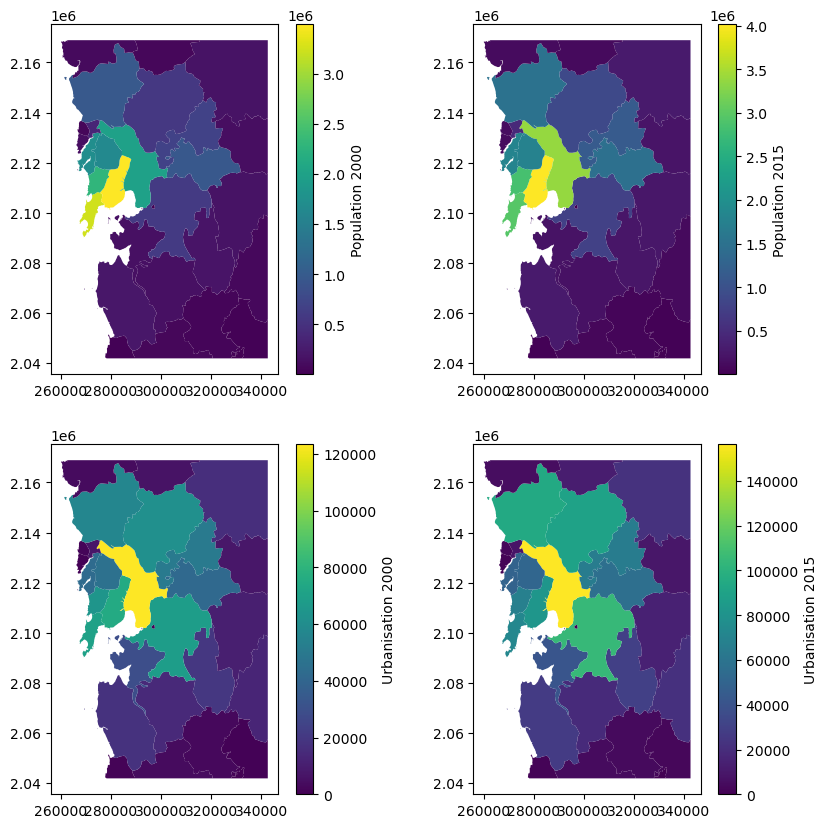

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

bu_pop_gdf.plot(column='pop_2000_sum', legend=True, ax=ax[0,0], cmap='viridis', legend_kwds={'label': "Population 2000", 'orientation': "vertical"})
bu_pop_gdf.plot(column='pop_2015_sum', legend=True, ax=ax[0,1], cmap='viridis', legend_kwds={'label': "Population 2015", 'orientation': "vertical"})

bu_pop_gdf.plot(column='bu_2000_count', legend=True, ax=ax[1,0], cmap='viridis', legend_kwds={'label': "Urbanisation 2000", 'orientation': "vertical"})
bu_pop_gdf.plot(column='bu_2015_count', legend=True, ax=ax[1,1], cmap='viridis', legend_kwds={'label': "Urbanisation 2015", 'orientation': "vertical"})

plt.show()

In [19]:
# calculating built up percentage per district
bu_pop_gdf['area'] = round(bu_pop_gdf.area, 4)
with rasterio.open(bu_2000_path) as raster:
    cell_area = raster.transform[0] * -raster.transform[4]
    bu_pop_gdf['bu2000_area'] = round(bu_pop_gdf['bu_2000_count'] * cell_area, 4)
with rasterio.open(bu_2015_path) as raster:
    cell_area = raster.transform[0] * -raster.transform[4]
    bu_pop_gdf['bu2015_area'] = round(bu_pop_gdf['bu_2015_count'] * cell_area, 4)

bu_pop_gdf['bu2000_pct'] = (bu_pop_gdf['bu2000_area'] / bu_pop_gdf['area']) * 100
bu_pop_gdf['bu2015_pct'] = (bu_pop_gdf['bu2015_area'] / bu_pop_gdf['area']) * 100

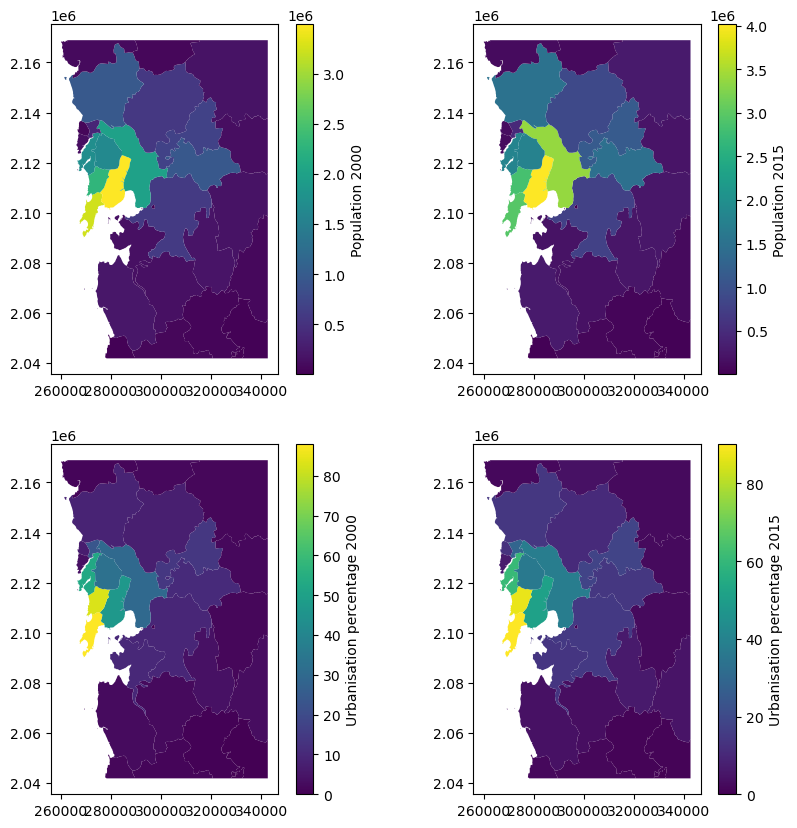

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

bu_pop_gdf.plot(column='pop_2000_sum', legend=True, ax=ax[0,0], cmap='viridis', legend_kwds={'label': "Population 2000", 'orientation': "vertical"})
bu_pop_gdf.plot(column='pop_2015_sum', legend=True, ax=ax[0,1], cmap='viridis', legend_kwds={'label': "Population 2015", 'orientation': "vertical"})

bu_pop_gdf.plot(column='bu2000_pct', legend=True, ax=ax[1,0], cmap='viridis', legend_kwds={'label': "Urbanisation percentage 2000", 'orientation': "vertical"})
bu_pop_gdf.plot(column='bu2015_pct', legend=True, ax=ax[1,1], cmap='viridis', legend_kwds={'label': "Urbanisation percentage 2015", 'orientation': "vertical"})

plt.show()

# 3. Green area per district

### Get Sentinel 2 data and calculate NDVI

In [4]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-alexandresantosgeographie') # Replace with your GEE project
print(ee.__version__)

0.1.406


In [5]:
# check if the authentication is working
print(ee.Image("JRC/GHSL/P2023A/GHS_POP/1975").getInfo())

{'type': 'Image', 'bands': [{'id': 'population_count', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [360820, 180000], 'crs': 'PROJCS["World_Mollweide", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH]], \n  PROJECTION["Mollweide"], \n  PARAMETER["semi_minor", 6378137.0], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  PARAMETER["central_meridian", 0.0], \n  UNIT["m", 1.0], \n  AXIS["Easting", EAST], \n  AXIS["Northing", NORTH]]', 'crs_transform': [100, 0, -18041000, 0, -100, 9000000]}], 'version': 1690185742435464, 'id': 'JRC/GHSL/P2023A/GHS_POP/1975', 'properties': {'system:time_start': 157766400000, 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], 

In [16]:
# methods from https://www.geo.fu-berlin.de/en/v/geo-it/gee/2-monitoring-ndvi-nbr/2-2-calculating-indices/ndvi-s2/index.html

def roi_ndvi(aoi_gdf):
    aoi_coords = aoi_gdf.to_crs(epsg='4326').envelope
    date_begin = '2018-01-01'
    date_end = '2018-12-31'
    #print('N',aoi_coords.bounds.values[0][3],'S',aoi_coords.bounds.values[0][1],'W',aoi_coords.bounds.values[0][0],'E',aoi_coords.bounds.values[0][2])
    transform = [aoi_coords.bounds.values[0][0], aoi_coords.bounds.values[0][1], aoi_coords.bounds.values[0][2], aoi_coords.bounds.values[0][3]]
    roi = ee.Geometry.BBox(west=transform[0], south=transform[1], east=transform[2], north=transform[3])
    
    s2=ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(roi).filterDate(date_begin, date_end).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 7)).median()
    # Use median to reduce noise and clouds

    # Calculate NDVI
    ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')  

    return ndvi

In [60]:
case_ndvi = roi_ndvi(AOI_gdf)

# Define visualization parameters
ndviParams = {min: 0,max: 1,'palette': ['blue', 'white', 'green']}

Map = geemap.Map()
# Visualize the NDVI
Map.centerObject(case_roi, 10)
Map.addLayer(case_ndvi.clip(case_roi), ndviParams, 'NDVI')
Map

Map(center=[19.030084093813997, 73.07880677975477], controls=(WidgetControl(options=['position', 'transparent_…

In [61]:
case_ndvi_clip = case_ndvi.clip(case_rec_roi)
print('MUM_NDVI stats:', check_image_stats(case_ndvi_clip, case_rec_roi))

MUM_NDVI stats: {'NDVI_max': 0.8944319279047312, 'NDVI_min': -0.956989247311828}


### calculate the green area stats
- Define the green area threshold
- Calculate count per pop in each district

In [ ]:
NDVI_2000_path = interim_path / ''
NDVI_2015_path = interim_path / ''

stats_list = ['count']
raster_dict = {'green_2000': NDVI_2000_path, 'green_2015': NDVI_2015_path}

veg_bu_pop_gdf = bu_pop_gdf

for value, key in raster_dict.items():
    veg_bu_pop_gdf = districts_stats(df = veg_bu_pop_gdf, 
                         raster_path = key, 
                         id='GID_3', 
                         title = value, 
                         stats_list=stats_list)

veg_bu_pop_gdf.head()

## export

In [114]:
gdf_path = interim_path / 'MUM_LIM_districts_stats_2000_2015_GADM4_A.shp'
df_export = bu_pop_gdf.infer_objects()
df_export['name'] = df_export['NAME_3'].astype(str)
df_export.drop(columns=['NAME_3'], inplace=True)
#df_export.loc[:,['GID_3', 'NAME_3']] = df_export.loc[:,['GID_3', 'NAME_3']].astype(str, copy=False)

df_export.dtypes
df_export.to_file(gdf_path, driver='ESRI Shapefile')

# 4.Income

In [24]:
# convert the MAN data from long database format to wide format
file_name = 'MAN_income_deciles_2021.xlsx'
sheet_name = "estimates"
cols = ['District','Province', 'Deciles','Income Total (In millions)']
income_df = pd.read_excel(external_path / file_name, sheet_name=sheet_name,skiprows=1, usecols=cols)
new_cols = ['district','province', 'deciles','income']
income_df.columns = new_cols
print('initial shape', income_df.shape)
# remove empty rows
income_df = income_df.dropna(how='any', subset=['income'])
print('edited shape', income_df.shape)

income_df['deciles'] = income_df['deciles'].str.replace(' Decile','')
replace_dict = {'First':'1', 'Second':'2', 'Third':'3', 'Fourth':'4', 
                'Fifth':'5', 'Sixth':'6', 'Seventh':'7', 'Eighth':'8', 
                'Ninth':'9', 'Tenth':'10',
                'Ratio of Upper 10 percent to Bottom 10 percent decile':'10_10_ratio',
                'Ratio of Upper 20 percent to Bottom 20 percent decile':'20_20_ratio',
                'Ratio of Upper 10 percent to Bottom 40 percent decile':'10_40_ratio'}
income_df['deciles'] = income_df['deciles'].replace(replace_dict)
income_df.head()

initial shape (466, 4)
edited shape (442, 4)


district     province deciles     income
0  Philippines  Philippines       1  306262.87
1  Philippines  Philippines       2  401607.22
2  Philippines  Philippines       3  464150.01
3  Philippines  Philippines       4  535044.82
4  Philippines  Philippines       5  601018.25

In [51]:
income_wide_df = income_df.pivot_table(index=['district', 'province'], columns='deciles', values='income', aggfunc='sum')

# Reset the index to flatten the DataFrame
income_wide_df.reset_index(inplace=True)

income_wide_df.head()

deciles district             province         1        10  10_10_ratio  \
0          NCR I       City of Manila  12756.53  36244.13         2.84   
1         NCR II  City of Mandaluyong   3956.37  11970.43         3.03   
2         NCR II     City of Marikina   2408.44  11660.71         4.84   
3         NCR II        City of Pasig   4587.14  19492.94         4.25   
4         NCR II     City of San Juan    869.95   3518.90         4.04   

deciles  10_40_ratio         2  20_20_ratio         3         4         5  \
0               0.61  14367.17         2.32  15252.71  17313.18  18312.17   
1               0.67   4231.84         2.41   4447.20   5169.04   5413.22   
2               0.88   2985.10         3.45   3725.41   4062.73   3960.24   
3               0.82   5527.01         3.04   6336.98   7181.14   8036.58   
4               0.84    924.42         3.11   1228.94   1177.94   1465.38   

deciles         6         7         8         9  
0        18747.08  21382.04  23313.65  26681.02  
1         5908.25   6108.50   7377.02   7770.84  
2         4452.57   5140.25   6136.91   6930.35  
3         8477.00   9076.68  11063.25  11258.18  
4         1263.61   1698.37   1634.49   2058.52

In [52]:

cols = income_wide_df.columns.tolist()
cols = cols[:3] + [cols[6]] + cols[8:] + cols[3:6] + [cols[7]]
#print(cols)
income_wide_df = income_wide_df[cols]
#income_wide_df.drop(columns=['deciles'], inplace=True)
income_wide_df.head()


deciles district             province         1         2         3         4  \
0          NCR I       City of Manila  12756.53  14367.17  15252.71  17313.18   
1         NCR II  City of Mandaluyong   3956.37   4231.84   4447.20   5169.04   
2         NCR II     City of Marikina   2408.44   2985.10   3725.41   4062.73   
3         NCR II        City of Pasig   4587.14   5527.01   6336.98   7181.14   
4         NCR II     City of San Juan    869.95    924.42   1228.94   1177.94   

deciles         5         6         7         8         9        10  \
0        18312.17  18747.08  21382.04  23313.65  26681.02  36244.13   
1         5413.22   5908.25   6108.50   7377.02   7770.84  11970.43   
2         3960.24   4452.57   5140.25   6136.91   6930.35  11660.71   
3         8036.58   8477.00   9076.68  11063.25  11258.18  19492.94   
4         1465.38   1263.61   1698.37   1634.49   2058.52   3518.90   

deciles  10_10_ratio  10_40_ratio  20_20_ratio  
0               2.84         0.61         2.32  
1               3.03         0.67         2.41  
2               4.84         0.88         3.45  
3               4.25         0.82         3.04  
4               4.04         0.84         3.11

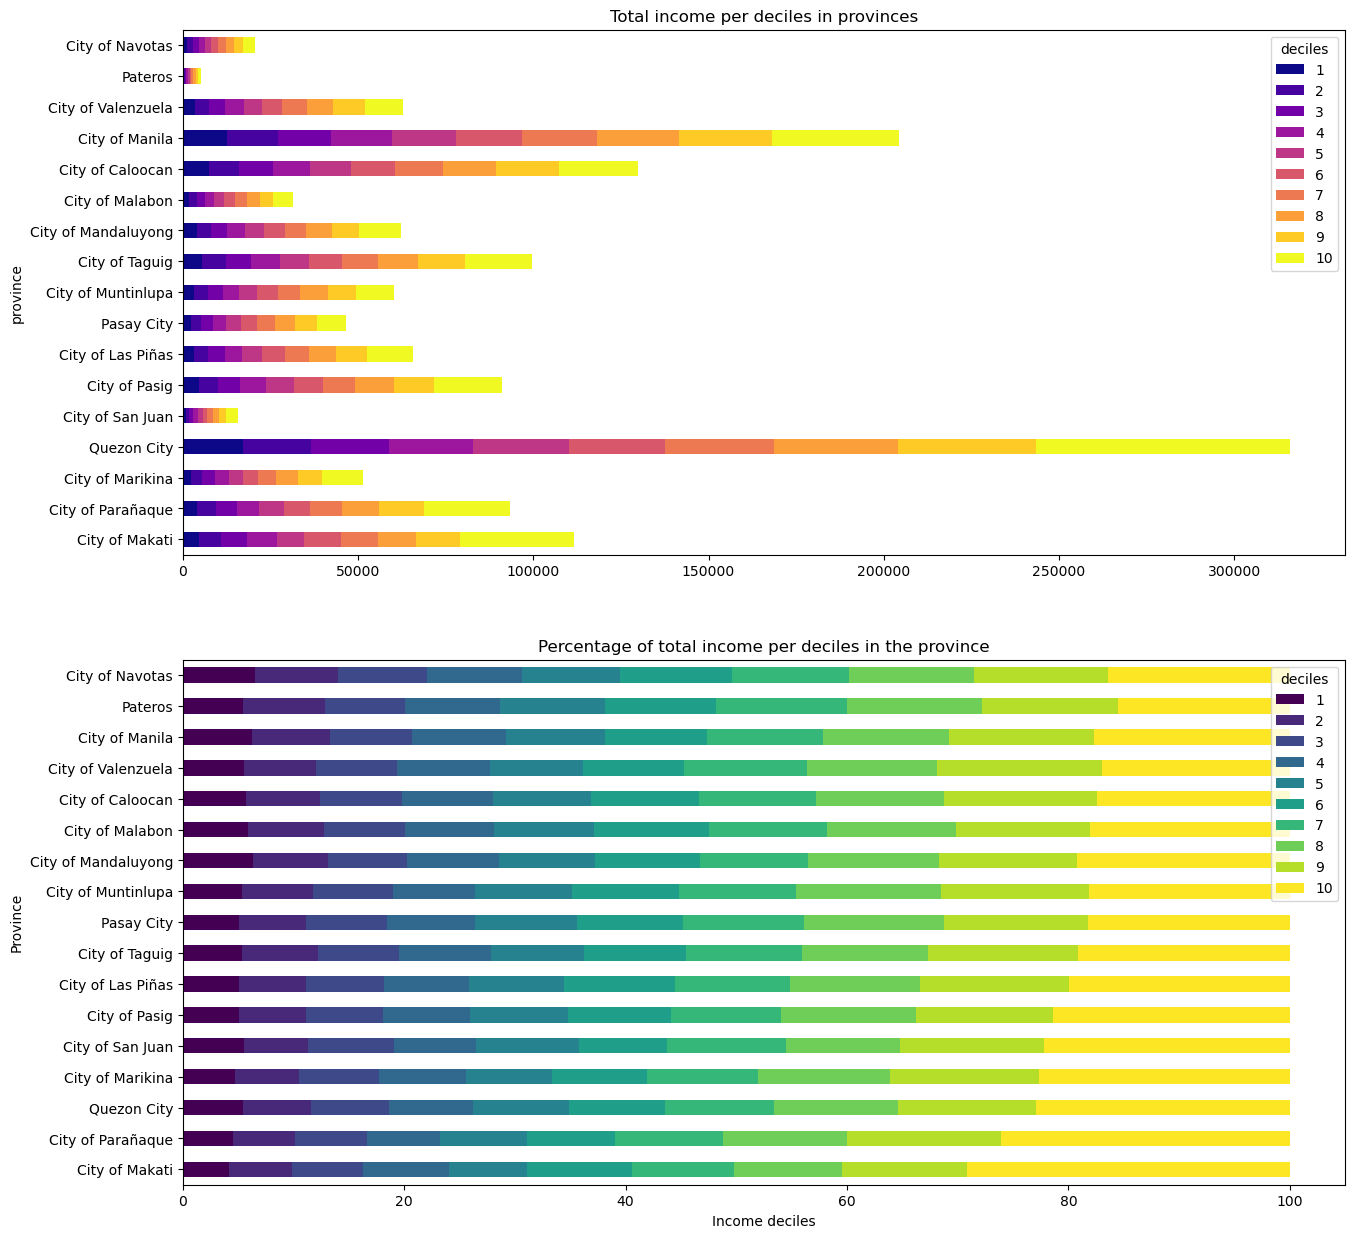

In [146]:
decile_list = ['1','2','3','4','5','6','7','8','9','10']
income_province_df = income_wide_df[(income_wide_df['province'] != 'Philippines')&
               (income_wide_df['province'] != 'National Capital Region')]
income_province_df['4th_decile'] = income_province_df[decile_list[0:4]].sum(axis=1) / income_province_df[decile_list].sum(axis=1)
df = income_province_df
sort_var = '10_40_ratio'

x_var = 'province'
y_var = decile_list

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
df.sort_values(by=sort_var, ascending=False, inplace=True)
f1 = df.plot(x=x_var,
             y=y_var, 
             kind='barh', 
             cmap = 'plasma',
             title='Total income per deciles in provinces',
             stacked=True, ax=ax[0])

df2 = pd.DataFrame(df.groupby(x_var)[y_var].sum())
df2 = df2.divide(df2.sum(axis=1), axis=0)*100
df2 = df2.merge(how='left', right=df[[x_var, sort_var]], on=x_var)

df2.sort_values(by=sort_var, ascending=False, inplace=True)

f2 = df2.plot(x= x_var,
              y = decile_list,
              kind='barh', 
             stacked=True, 
             cmap='viridis',
             title='Percentage of total income per deciles in the province', 
             ax=ax[1])
ax[1].set_xlabel('Income deciles')
ax[1].set_ylabel('Province')

plt.show()

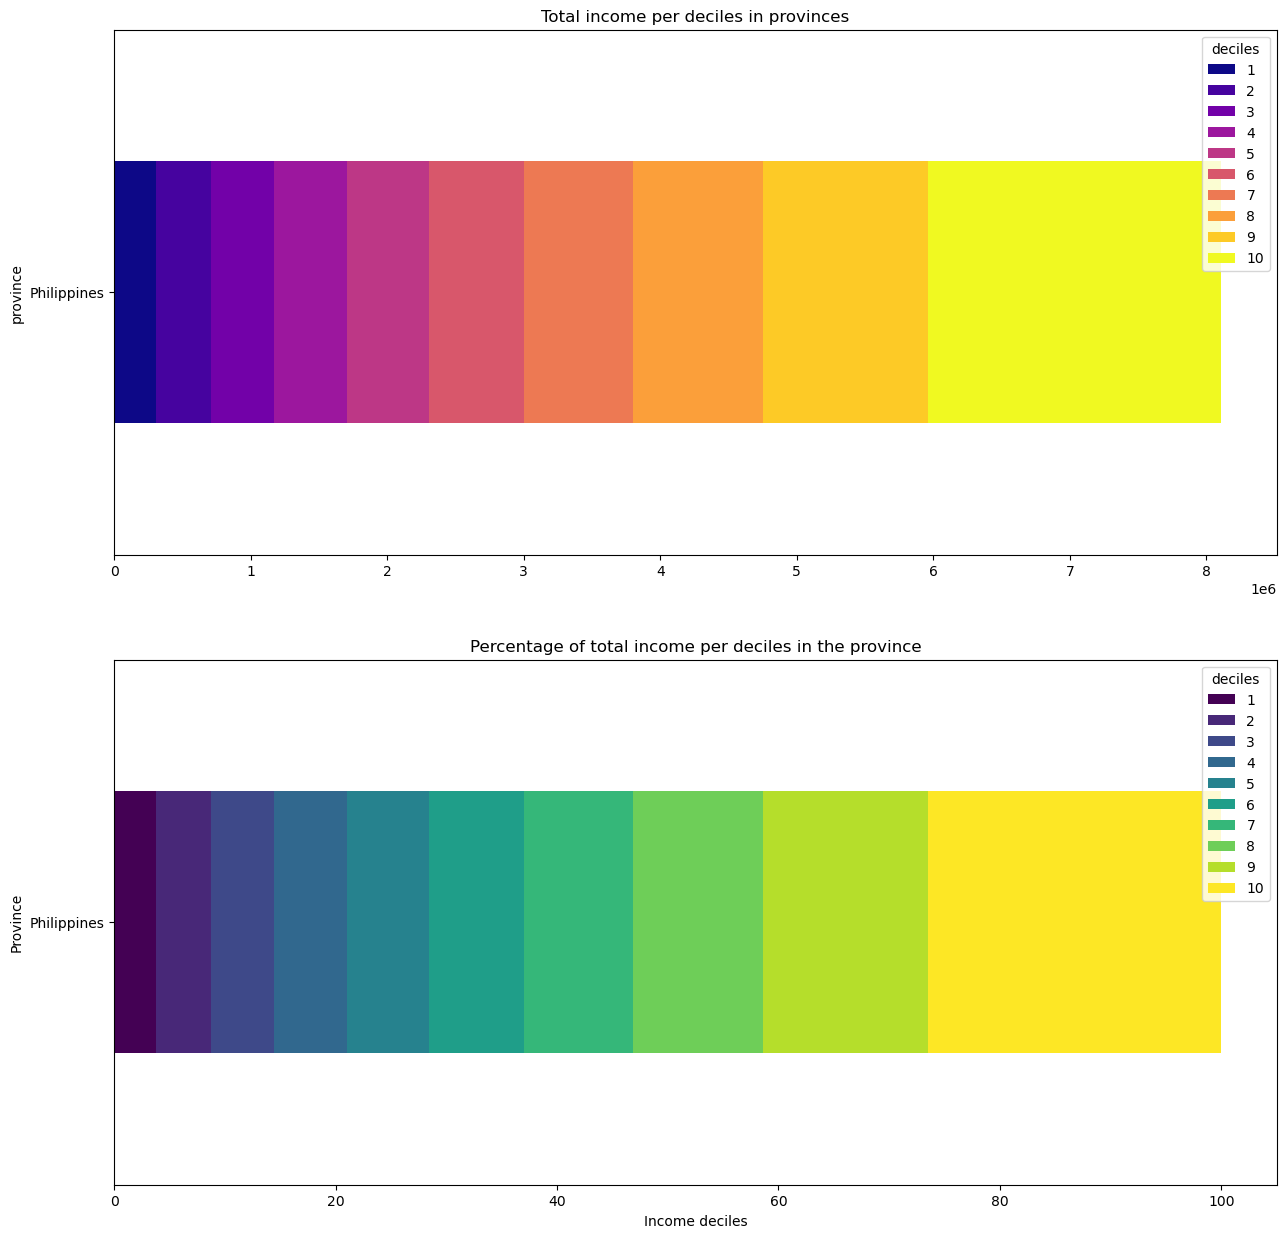

In [147]:
# explore the income data
philippines_df = income_wide_df[income_wide_df['province'] == 'Philippines']

df = philippines_df
sort_var = '10_40_ratio'

x_var = 'province'
y_var = decile_list

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
df.sort_values(by=sort_var, ascending=False, inplace=True)
f1 = df.plot(x=x_var,
             y=y_var, 
             kind='barh', 
             cmap = 'plasma',
             title='Total income per deciles in provinces',
             stacked=True, ax=ax[0])

df2 = pd.DataFrame(df.groupby(x_var)[y_var].sum())
df2 = df2.divide(df2.sum(axis=1), axis=0)*100
df2 = df2.merge(how='left', right=df[[x_var, sort_var]], on=x_var)

df2.sort_values(by=sort_var, ascending=False, inplace=True)

f2 = df2.plot(x= x_var,
              y = decile_list,
              kind='barh', 
             stacked=True, 
             cmap='viridis',
             title='Percentage of total income per deciles in the province', 
             ax=ax[1])
ax[1].set_xlabel('Income deciles')
ax[1].set_ylabel('Province')

plt.show()

In [159]:
for i in range(len(decile_list)):
    print((i+1)*10,'% pop has',round(float(df2.loc[:,decile_list[0:i+1]].sum(axis=1)),2),'% of the income')

10 % pop has 3.78 % of the income
20 % pop has 8.73 % of the income
30 % pop has 14.45 % of the income
40 % pop has 21.05 % of the income
50 % pop has 28.46 % of the income
60 % pop has 36.98 % of the income
70 % pop has 46.85 % of the income
80 % pop has 58.62 % of the income
90 % pop has 73.5 % of the income
100 % pop has 100.0 % of the income


In [139]:
df2

deciles             province         1         2         3         4  \
0           City of Caloocan  5.735676  6.663437  7.422796  8.181470   
1          City of Las Piñas  5.087213  6.063726  7.047803  7.662497   
2             City of Makati  4.177758  5.677928  6.459906  7.691557   
3            City of Malabon  5.892618  6.877773  7.323524  8.052112   
4        City of Mandaluyong  6.345145  6.786938  7.132328  8.290001   
5             City of Manila  6.241890  7.029991  7.463294  8.471501   
6           City of Marikina  4.679971  5.800511  7.239047  7.894512   
7         City of Muntinlupa  5.336843  6.417124  7.225476  7.387786   
8            City of Navotas  6.516314  7.472918  8.041371  8.651852   
9          City of Parañaque  4.498289  5.645506  6.496876  6.600137   
10             City of Pasig  5.038770  6.071176  6.960892  7.888164   
11          City of San Juan  5.491928  5.835793  7.758205  7.436246   
12            City of Taguig  5.368564  6.877788  7.249004  8.322542   
13        City of Valenzuela  5.502253  6.548807  7.277091  8.435805   
14                Pasay City  5.062578  6.086356  7.258254  8.001336   
15                   Pateros  5.412281  7.428048  7.261785  8.561659   
16               Quezon City  5.465985  6.079666  7.091423  7.561025   

deciles         5          6          7          8          9         10  \
0        8.873516   9.730422  10.542643  11.564094  13.857285  17.428660   
1        8.574771  10.011256  10.365757  11.814945  13.379376  19.992657   
2        7.042422   9.511459   9.241694   9.714453  11.336111  29.146711   
3        8.970172  10.377640  10.673533  11.700149  12.054985  18.077495   
4        8.681611   9.475530   9.796687  11.831114  12.462714  19.197931   
5        8.960316   9.173122  10.462433  11.407587  13.055273  17.734593   
6        7.695358   8.652032   9.988300  11.924965  13.466741  22.658562   
7        8.781012   9.664161  10.589699  13.081074  13.402779  18.114046   
8        8.808994  10.119961  10.566717  11.259792  12.155157  16.406924   
9        7.846002   7.908778   9.839870  11.188277  13.850475  26.125790   
10       8.827827   9.311609   9.970331  12.152490  12.366612  21.412131   
11       9.250833   7.977074  10.721681  10.318411  12.995280  22.214549   
12       8.385798   9.253709  10.515741  11.321920  13.597637  19.107297   
13       8.389844   9.135751  11.117926  11.760970  14.876486  16.955065   
14       9.202588   9.598559  10.856549  12.681197  13.009617  18.242967   
15       9.513892   9.964981  11.814484  12.192355  12.337614  15.512903   
16       8.690065   8.624192   9.874891  11.250379  12.410207  22.952168   

deciles  4th_decile  
0          0.280034  
1          0.258612  
2          0.240071  
3          0.281460  
4          0.285544  
5          0.292067  
6          0.256140  
7          0.263672  
8          0.306825  
9          0.232408  
10         0.259590  
11         0.265222  
12         0.278179  
13         0.277640  
14         0.264085  
15         0.286638  
16         0.261981

In [133]:
income_province_df.loc[:,['province','4th_decile','10_10_ratio']] 


deciles             province  4th_decile  10_10_ratio
0             City of Manila    0.292067         2.84
1        City of Mandaluyong    0.285544         3.03
2           City of Marikina    0.256140         4.84
3              City of Pasig    0.259590         4.25
4           City of San Juan    0.265222         4.04
5                Quezon City    0.261981         4.20
6           City of Caloocan    0.280034         3.04
7            City of Malabon    0.281460         3.07
8            City of Navotas    0.306825         2.52
9         City of Valenzuela    0.277640         3.08
10         City of Las Piñas    0.258612         3.93
11            City of Makati    0.240071         6.98
12        City of Muntinlupa    0.263672         3.39
13         City of Parañaque    0.232408         5.81
14            City of Taguig    0.278179         3.56
15                Pasay City    0.264085         3.60
16                   Pateros    0.286638         2.87

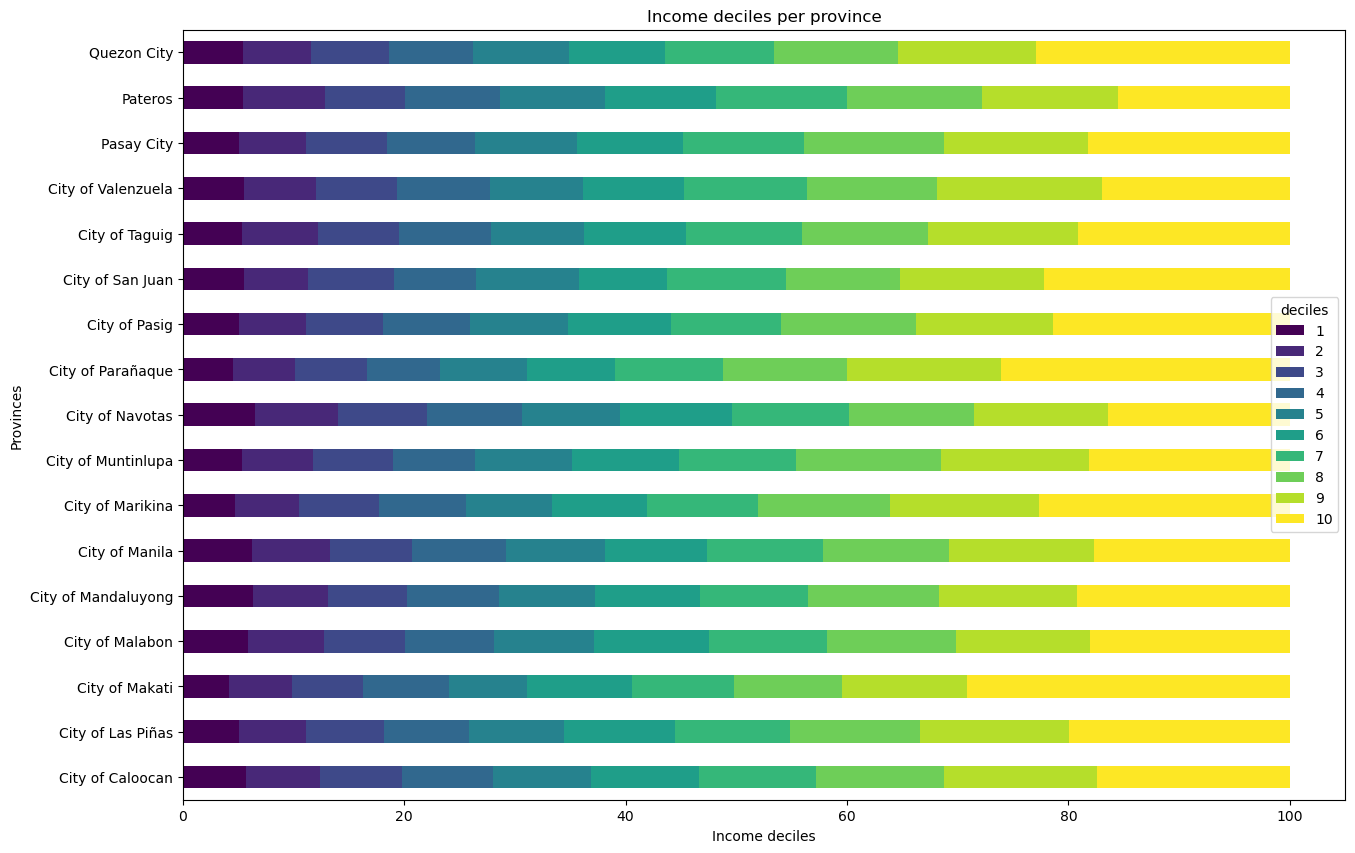

In [105]:
df = income_province_df
x_var = 'province'
#y_var = ['1', '2']
y_var = ['1','2','3','4','5','6','7','8','9','10']

df = pd.DataFrame(df.groupby(x_var)[y_var].sum())
df = df.divide(df.sum(axis=1), axis=0)*100
ax = df.plot(kind='barh', 
             stacked=True, 
             cmap='viridis',
             title='Income deciles per province')
ax.set_xlabel('Income deciles')
ax.set_ylabel('Provinces')

#for i, v in df.reset_index(drop=True).iterrows():
#    for val in v:
        #plt.text(x=val,y=i, s=str(round(val,2))+'%', size=12)

plt.show()

# 10 resettlement suitability
Develop a suitability measure for resettlement sites.
Tasks:
1. Load environmental layers
2. Calculate a general suitability measure (weighted sum)
3. Load resettlement site points
4. Calculate spatial statistics for each point and aggrete for all points
5. Plot maps and graphs reporting the results
6. Export calculated results to shape and CSV files

In [33]:
# set the environment for the model.
# calibrate =True means loading values for the initial year in the simulation (e.g. 2000)
# calibrate = False means loading values for the second time reference in the simulation (e.g. 2015)

calibrate = True

if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.tif'

loading_dict = {'slope.asc': case_city + '_DEM_slope_pct_TanDEM_X_150m.tif', 
                 'exclusion.asc': case_city + '_lim_exclusion_layer_150m.tif', 
                 'districts.asc': case_city + '_lim_districts_gadm4_150m.tif',
                 'structureplan.asc': case_city + '_LIM_non_residential_areas_150m.tif', # APS: MUM and JAK still need defining
                 #'income.asc': case_city + '_pop_census_income_150m.asc',  # APS 18.11.2024 Need to estimate for Manila
                 'airport.asc': case_city + '_LOC_airports_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                 'attractive2000.asc': case_city + '_LOC_attractive_areas_cost_OSM_2024.tif', # APS: I need to replace this file with the actual 2000 data
                 'attractive2015.asc': case_city + '_LOC_attractive_areas_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
                 'cbd.asc': case_city + '_LOC_CBDs_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
                 'healthfacilities.asc': case_city + '_LOC_health_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',  
                 'shoppingmalls.asc': case_city + '_LOC_malls_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
                 'markets.asc': case_city + '_LOC_markets_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
                 'schools.asc': case_city + '_LOC_schools_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
                 'suburban.asc': case_city + '_LOC_suburban_centres_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
                 'roads.asc': case_city + '_LOC_roads_cost_OSM_2024.tif', 
                 'bu2000_dist.asc': case_city + '_LOC_urbanisation2000_cost_150m.tif', 
                 'bu2015_dist.asc': case_city + '_LOC_urbanisation2015_cost_150m.tif', 
                 'tenure.asc': case_city + '_urb_tenure_150m.tif', 
                 'density2000.asc': case_city + '_pop_density_normal_2000_wdpop_150m.tif',
                 'density2015.asc': case_city + '_pop_density_normal_2015_wdpop_150m.tif', 
                 'landvalue.asc': real_estate_path,
                 'road-presence.asc': case_city + '_tra_roads_osm_2024_l_all_150m.tif', 
                 'urban2000.asc': case_city + '_urb_urbanisation_2000_eoc_wuf_150m.tif', 
                 'urban2015.asc': case_city + '_urb_urbanisation_2015_eoc_wuf_150m.tif',
                 'water.asc': case_city + '_LOC_water_cost_OSM_2024.tif',
                 'rivers.asc': case_city + '_LOC_rivers_cost_OSM_2024.tif'
}
layers_files_2000_dict = {'suburban':'suburban.asc', 
                          'bu':'bu2000_dist.asc', 
                          'real_estate':'landvalue.asc',
                          'road':'roads.asc', 
                          'social': None,
                          #'density':'density2015.asc', 
                          'schools': 'schools.asc', 
                          'health':'healthfacilities.asc', 
                          'coast': 'water.asc',
                          'rivers': 'rivers.asc' }	#'rivers.asc'

layers_files_2015_dict = {'suburban':'suburban.asc', 
                          'bu':'bu2015_dist.asc', 
                          'real_estate':'landvalue.asc',
                          'road':'roads.asc', 
                          'social': None,
                          #'density':'density2015.asc', 
                          'schools': 'schools.asc', 
                          'health':'healthfacilities.asc', 
                          'coast': 'water.asc',
                          'rivers': 'rivers.asc'}	#


if calibrate:
    files_dict = layers_files_2000_dict
    suit_layers_list = list(layers_files_2000_dict.keys())
else:
    files_dict = layers_files_2015_dict
    suit_layers_list = list(layers_files_2015_dict.keys())




## 1. Load environmental layers

In [48]:
no_file_list = []
suit_raster_dict = {}
for layer in suit_layers_list:	
    #print(layer)
    
    file_name = files_dict[layer]
    #print(file_name)
    if file_name != None:
        url = model_inputs_SLEUTH_150m_path / loading_dict[file_name]
        #print(layer,url)
    else:
        url = None
    
    try:
        with rasterio.open(url) as src:
            raster = src.read(1)
            #if raster.max() > 1:
                # normalize the raster values
                #raster = (raster - np.nanmin(raster))/(np.nanmax(raster) - np.nanmin(raster))
            if raster.min() < 0:
                raster = np.where(raster < 0, 0, raster)
            suit_raster_dict[layer] = raster
            print(layer,'shape:',raster.shape)
    except:
        print(layer,'has no file')
        no_file_list.append(layer)
    
print('create stand-in rasters for:',no_file_list)

# calculate 'social' based on health and schools
suit_raster_dict['social'] = suit_raster_dict['schools'] + suit_raster_dict['health']
# normalize the social raster
#suit_raster_dict['social'] = (suit_raster_dict['social'] - np.nanmin(suit_raster_dict['social']))/(np.nanmax(suit_raster_dict['social']) - np.nanmin(suit_raster_dict['social']))

# calculate the complements for cost layers
cost_list = []
cost_list = [] #
for layer in cost_list:
    suit_raster_dict[layer] = 1 - suit_raster_dict[layer]
# normalize rasters which have values > 1
for key, value in suit_raster_dict.items():
    if value.max() > 1:
        suit_raster_dict[key] = (value - np.nanmin(value))/(np.nanmax(value) - np.nanmin(value))

for key, value in suit_raster_dict.items():
    print(key, value.shape, 'min:', np.nanmin(value), 'max:', np.nanmax(value))


suburban shape: (704, 533)
bu shape: (704, 533)
real_estate shape: (704, 533)
road shape: (704, 533)
social has no file
schools shape: (704, 533)
health shape: (704, 533)
coast shape: (704, 533)
rivers shape: (704, 533)
create stand-in rasters for: ['social']
suburban (704, 533) min: 0.0 max: 1.0
bu (704, 533) min: 0.0 max: 1.0
real_estate (704, 533) min: 0.0 max: 1.0
road (704, 533) min: 0.0 max: 1.0
schools (704, 533) min: 0.0 max: 1.0
health (704, 533) min: 0.0 max: 1.0
coast (704, 533) min: 0.0 max: 1.0
rivers (704, 533) min: 0.0 max: 1.0
social (704, 533) min: 0.0 max: 1.0


## 2. Calculate a general suitability measure (weighted sum)

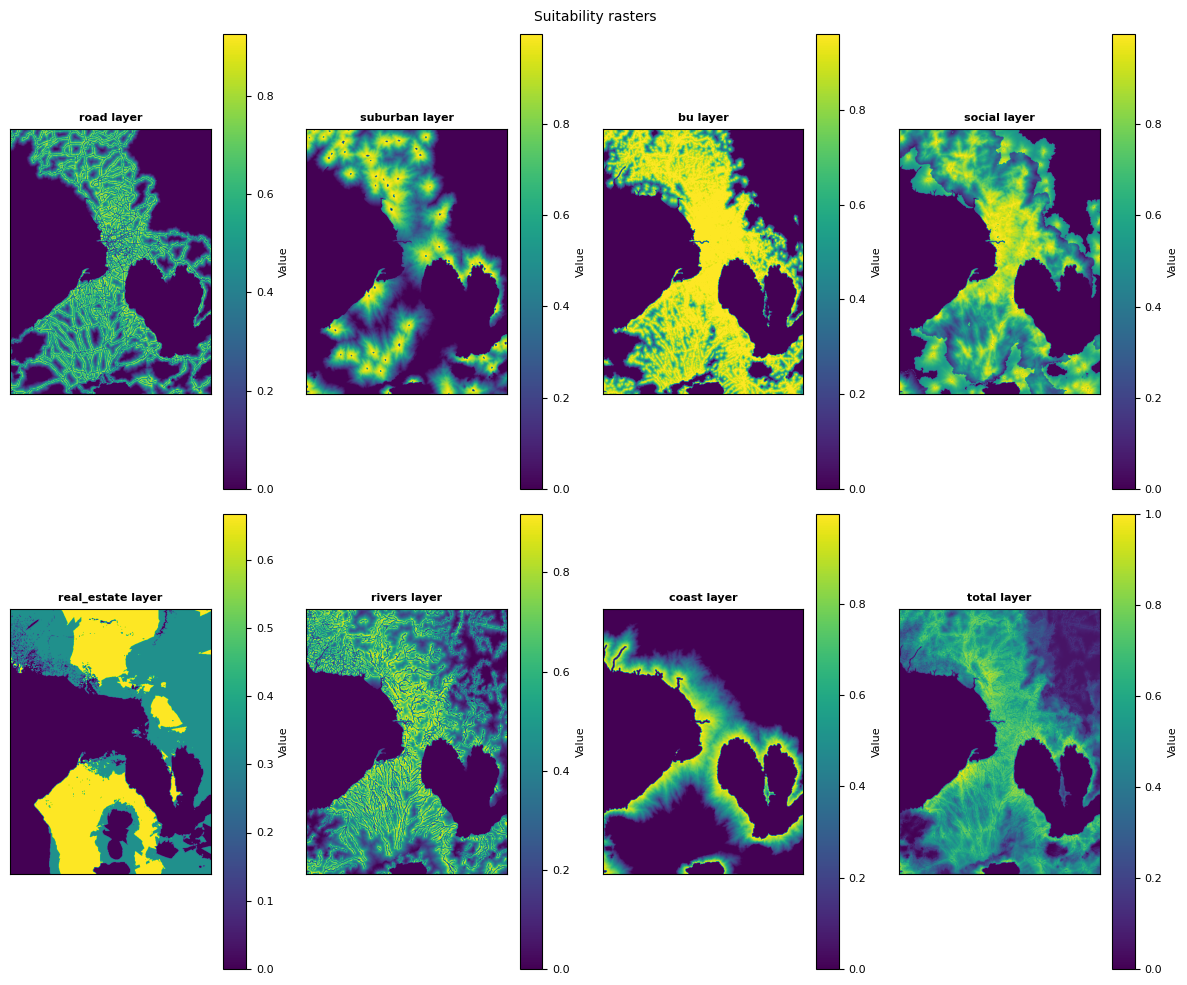

In [49]:
%run ./ti_city_00_raster_functions.ipynb

suitability_dict = {'road':1,'suburban':1,'bu':1,'social':1, 'real_estate':1,'rivers':1,'coast':1}

suitability_dict = calculate_utility(suit_raster_dict, suitability_dict)

plot_many_rasters(raster_dict=suitability_dict, 
                  fig_title='Suitability rasters',
                  ref_raster_path = ref_raster_sleuth_path, 
                  subplot_title=' layer')

## 3. Load resettlement site points

## 4. Calculate spatial statistics for each point and aggrete for all points

## 5. Plot maps and graphs reporting the results

## 6. Export calculated results to shape and CSV files

# 20 preview Ti-City layers

## 20.1 Suitability

to load-suitability
  set slope_max max [slope] of patches
  set develop_prob [] ;; APS: initializes a list called develop_prob
  let a 0
  while [a <= critical_slope][ ;; APS:  The code loops through values of a from 0 to critical_slope
    let b (critical_slope - a) / critical_slope ;; APS: Calculates a normalized value b that ranges from 1 (when a = 0) to 0 (when a = critical_slope). This essentially creates a probability scaling factor for slopes below the critical_slope.
    set develop_prob lput (b ^ (slope_coefficient / 200)) develop_prob ;; APS: Appends (lput) a development probability for each slope based on the value of b and the slope_coefficient. The term (b ^ (slope_coefficient / 200)) reduces the development probability as slope increases.
    set a a + 1]
  let i 1
  while [i <= (slope_max - critical_slope)][ ;; APS: Loops to add zeros to the develop_prob list for slopes greater than critical_slope.
    set develop_prob lput 0 develop_prob ;; APS: Appends a zero to the develop_prob list, indicating no development probability for slopes beyond the critical_slope.
    set i i + 1]

  ask patches [
    let y random-float 1 ;; APS: Generates a random number y between 0 and 1 for each patch.
    ifelse y < item slope  develop_prob ;; APS: Compares the random number y to the development probability for the patch's slope (obtained from the develop_prob list). If y is less than the probability:
    [set suitability 1] ;; APS: The patch is deemed suitable for development (suitability = 1).
    [set suitability 0] ;; APS: Otherwise, the patch is unsuitable for development
    if exclusion = 1 [set suitability 0]
    if urban = 1 [set suitability 0]
  ]
end

Min value: 0 , Max value: 1


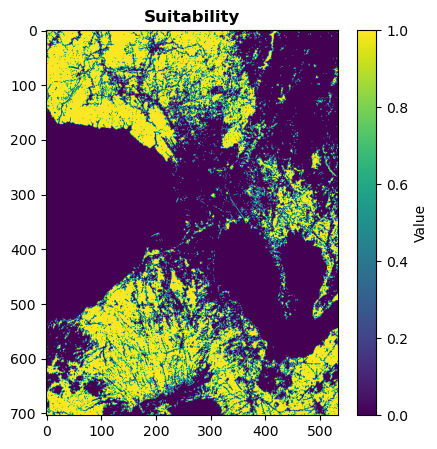

In [44]:
%run ./ti_city_00_raster_functions.ipynb

slope_raster_path = ti_city_ascii_path / 'slope.asc'
exclusion_file = ti_city_ascii_path / 'exclusion.asc'
urban_2000_file = ti_city_ascii_path / 'urban2000.asc'
urban_2015_file = ti_city_ascii_path / 'urban2015.asc'
urban_raster = urban_2015_file

suitability = calculate_suitability(slope_raster_path, exclusion_file, urban_raster)

plot_continuous_raster(suitability, 'Suitability')

## Adjusting suitability with a geometric distance to roads in addition to slope

Min value: 0.0 , Max value: 1.0


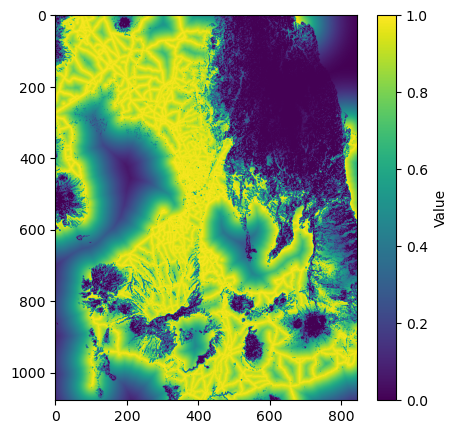

In [19]:
slope_raster_path = ti_city_ascii_path / 'slope.asc'
with rasterio.open(slope_raster_path) as src:
    slope_array = src.read(1)
    slope_meta = src.meta
    slope_transform = src.transform
    slope_max = np.nanmax(slope_array)
    develop_prob = []
    critical_slope = 25
    slope_coefficient = 11
    for a in range(critical_slope):
        b = (critical_slope - a) / critical_slope
        develop_prob.append(b ** (slope_coefficient/200))
    for i in range(int(slope_max - critical_slope)):
        develop_prob.append(0)
    #plot_continuous_raster(slope_array, 'Slope')

# create an array of zeros to store the develop probability with the same shape as the slope array
develop_prob_a_array = np.zeros(slope_array.shape, dtype=np.float32)

# loop through the slope array and calculate the develop probability of each cell
for i in range(slope_array.shape[0]):
    for j in range(slope_array.shape[1]):
        if slope_array[i,j] < critical_slope:
            slope = slope_array[i,j]
            develop_prob_a_array[i,j] = ((critical_slope - slope) / critical_slope) ** (slope_coefficient / 200)
#plot_continuous_raster(develop_prob_array)

# adjusting the probability array A to the road distance
roads_raster_path = ti_city_ascii_path / 'roads.asc'

# Enhance the contrast using a power-law transformation
# Exponent > 1 increases contrast between high and low values
scale_factor = 2.5

with rasterio.open(roads_raster_path) as src:
    roads_array = 1 - src.read(1)
    
    # power law transformation
    road_influence = np.power(roads_array, scale_factor)
    #plot_continuous_raster(road_influence, 'Roads')

develop_prob_b_array = develop_prob_a_array * road_influence
plot_continuous_raster(develop_prob_b_array)

Min value: 0 , Max value: 1


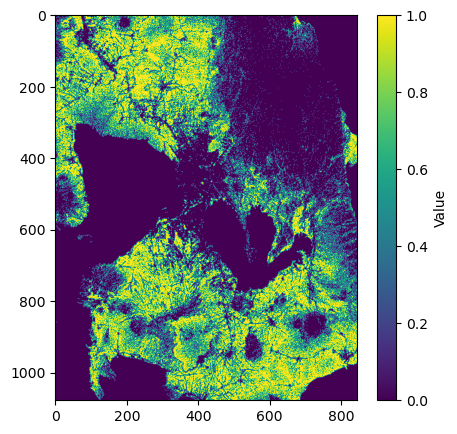

In [22]:
# set suitability values 
# generate a random raster from 0 to 1 with the dimensions of the slope raster
exclusion_file = ti_city_ascii_path / 'exclusion.asc'
urban_2000_file = ti_city_ascii_path / 'urban2000.asc'
urban_2015_file = ti_city_ascii_path / 'urban2015.asc'
urban_raster = urban_2015_file

rand_array = np.random.rand(slope_array.shape[0], slope_array.shape[1])
suitability_array = np.where(rand_array <= develop_prob_b_array, 1, 0)


with rasterio.open(exclusion_file) as src:
    exclusion_array = src.read(1)
    suitability_array = np.where(exclusion_array == 1, 0, suitability_array)

with rasterio.open(urban_raster) as src:
    urban_array = src.read(1)
    suitability_array = np.where(urban_array == 1, 0, suitability_array)

plot_continuous_raster(suitability_array)

## 20.2 Informal development

;; COMPUTE LEGAL STATUS OF PARCELS
;;Load areas liable to informal development
to load-informality
  ;; ask patches with [(suitability = 1) and (structureplan != 1 and structureplan != 4 and structureplan != 0)]
  ask patches with [(suitability = 1) and (structureplan = 1)] ;; APS: structureplan is now a binary variable, where 0 = settlement allowed, and 1 = settlement not allowed
    [set informality 1]
end


;;Display areas liable to informal development
to display-areas-liable-to-informality
  let i count patches with [(informality = 1) and (suitability = 1) and (urban = 0)]
  let j (development_control / 100) * i
  ;;ask n-of j patches with [informality = 1 and splan != 7] [set pcolor red]
  ask n-of j patches with [(informality = 1) and (suitability = 1) and (urban = 0)] [set pcolor red]
end


;;load informal lands that are available for development
to load-informal-avail
  let i count patches with [(informality = 1) and (suitability = 1) and (urban = 0)]
  let j (development_control / 100) * i
  ask n-of j patches with [(informality = 1) and (suitability = 1) and (urban = 0)]
    [set informal_avail 1]
   ;; exclude the specified proportion of informal lands from development
end
;;..............................................................................
;;..............................................................................

## 20.3 Utility

;; APS: new function to help set the weights
to set-weights
  ;; deprived agents
  set [ dpu-suburb dpu-neigbhour dpu-bu dpu-cbd dpu-mall dpu-markets dpu-road dpu-density dpu-schools dpu-attractive dpu-health dpu-random dpu-water ]
  [ 3 9 9 4 2 7 3 9 4 1 2 1 10 ]
  ;; low income agents
  set [ liu-suburb liu-neigbhour liu-bu liu-cbd liu-mall liu-markets liu-road liu-density liu-schools liu-attractive liu-health liu-random liu-water ]
  [ 8 7 9 7 2 7 8 9 4 2 4 1 7 ]
  ;; middle income agents
  set [ miu-suburb miu-neigbhour miu-bu miu-cbd miu-mall miu-markets miu-road miu-density miu-schools miu-attractive miu-health miu-random miu-water ]
  [ 6 7 7 4 7 7 6 6 4 7 4 1 5 ]
  ;; high income agents
  set [ hiu-suburb hiu-neigbhour hiu-bu hiu-cbd hiu-mall hiu-markets hiu-road hiu-density hiu-schools hiu-attractive hiu-health hiu-random hiu-water ]
  [ 5 7 2 7 9 6 5 1 4 10 3 1 8 ]
end

;; load low income households utility for each parcel
to load-ULI
  ask patches [
    set ULI (((1 - suburb) * liu-suburb) + (nom-neighbourhood * liu-neigbhour) + ((1 - bu) * liu-bu) +
      ((1 - cbd) * liu-cbd) + ((1 - shoppingmall) * liu-mall) + ((1 - markets) * liu-markets) +
      ((1 - road) * liu-road) + (density * liu-density) + ((1 - schools) * liu-schools) +
      ((1 - attractive) * liu-attractive) + ((1 - healthfacilities) * liu-health ) + ((random-float 0.1) * liu-random))
  ]
end

to make-low-income-household-development
  let i household-number
  let n percent-low-income-households
  let x ((i / simulation-period) * ( n / 100)) ;; the number of low-income households who enter the market annually between 2000 and 2010

  let d patches with [(urban = 0) and (new-urban = 0) and (suitability = 1) and (landvalue < 2)]

  ;;ask max-n-of (x + (count d) / 20) d [ULI] [set first-n-ULI 1]

  ask max-n-of (x * 3) d [ULI] [set first-n-ULI 1]

  ask n-of x households with [income-status = 1 and LIH-movement = 0][
    move-to one-of patches with
    [((first-n-ULI = 1) and (LI-movement = 0) and (HI-movement = 0) and
      (MI-movement = 0) and (pMED-movement = 0) and (pHED-movement = 0))]

    ask patch-here
    [(set pcolor yellow) (set LI-movement 1) (set new-urban 1)]

    set LIH-movement 1
    set color yellow
  ]
end

### Set weights

### Import model inputs

In [3]:
%run ./ti_city_00_raster_functions.ipynb

ut_raster_dict = {}

# set the environment for the model.
# calibrate =True means loading values for the initial year in the simulation (e.g. 2000)
# calibrate = False means loading values for the second time reference in the simulation (e.g. 2015)

calibrate = False

if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc'

loading_dict = {'slope.asc': case_city + '_DEM_slope_pct_TanDEM_X_150m.tif', 
                 'exclusion.asc': case_city + '_lim_exclusion_layer_150m.tif', 
                 'districts.asc': case_city + '_lim_districts_gadm4_150m.tif',
                 'structureplan.asc': case_city + '_LIM_non_residential_areas_150m.tif', # APS: MUM and JAK still need defining
                 #'income.asc': case_city + '_pop_census_income_150m.asc',  # APS 18.11.2024 Need to estimate for Manila
                 'airport.asc': case_city + '_LOC_airports_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                 'attractive2000.asc': case_city + '_LOC_attractive_areas_cost_OSM_2024.tif', # APS: I need to replace this file with the actual 2000 data
                 'attractive2015.asc': case_city + '_LOC_attractive_areas_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
                 'cbd.asc': case_city + '_LOC_CBDs_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
                 'healthfacilities.asc': case_city + '_LOC_health_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',  
                 'shoppingmalls.asc': case_city + '_LOC_malls_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
                 'markets.asc': case_city + '_LOC_markets_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
                 'schools.asc': case_city + '_LOC_schools_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
                 'suburban.asc': case_city + '_LOC_suburban_centres_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
                 'roads.asc': case_city + '_LOC_roads_cost_OSM_2024.tif', 
                 'bu2000_dist.asc': case_city + '_LOC_urbanisation2000_cost_150m.tif', 
                 'bu2015_dist.asc': case_city + '_LOC_urbanisation2015_cost_150m.tif', 
                 'tenure.asc': case_city + '_urb_tenure_150m.tif', 
                 'density2000.asc': case_city + '_pop_density_normal_2000_wdpop_150m.tif',
                 'density2015.asc': case_city + '_pop_density_normal_2015_wdpop_150m.tif', 
                 'landvalue.asc': real_estate_path,
                 'road-presence.asc': case_city + '_tra_roads_osm_2024_l_all_150m.tif', 
                 'urban2000.asc': case_city + '_urb_urbanisation_2000_eoc_wuf_150m.tif', 
                 'urban2015.asc': case_city + '_urb_urbanisation_2015_eoc_wuf_150m.tif',
                 'water.asc': case_city + '_LOC_water_cost_OSM_2024.tif'
}
layers_files_2000_dict = {'suburban': 'suburban.asc', 
                          'neighbour':None, 
                          'bu':'bu2000_dist.asc', 
                          'cbd':'cbd.asc', 
                          'mall':'shoppingmalls.asc', 
                          'markets':'markets.asc', 
                          'road':'roads.asc', 
                          'density':'density2000.asc', 
                          'schools': 'schools.asc', 
                          'attractive':'attractive2000.asc', 
                          'health':'healthfacilities.asc', 
                          'random':None, 
                          'water': 'water.asc'}
layers_files_2015_dict = {'suburban':'suburban.asc', 
                          'neighbour':None, 
                          'bu':'bu2015_dist.asc', 
                          'cbd':'cbd.asc', 
                          'mall':'shoppingmalls.asc', 
                          'markets':'markets.asc', 
                          'road':'roads.asc', 
                          'density':'density2015.asc', 
                          'schools': 'schools.asc', 
                          'attractive':'attractive2015.asc', 
                          'health':'healthfacilities.asc', 
                          'random':None, 
                          'water': 'water.asc'}
if calibrate:
    files_dict = layers_files_2000_dict
    ut_layers_list = list(layers_files_2000_dict.keys())
else:
    files_dict = layers_files_2015_dict
    ut_layers_list = list(layers_files_2015_dict.keys())

dp_wt_list = [3, 9, 9, 4, 2, 7, 3, 9, 4, 2, 2, 1, 10]
li_wt_list = [8, 7, 9, 7, 2, 7, 8, 9, 4, 2, 4, 1, 7]
mi_wt_list = [6, 7, 7, 4, 7, 7, 6, 6, 4, 7, 4, 1, 5]
hi_wt_list = [5, 7, 2, 7, 9, 6, 5, 1, 4, 10, 3, 1, 8]

dp_wt_dict = dict(zip(ut_layers_list, dp_wt_list))
li_wt_dict = dict(zip(ut_layers_list, li_wt_list))
mi_wt_dict = dict(zip(ut_layers_list, mi_wt_list))
hi_wt_dict = dict(zip(ut_layers_list, hi_wt_list))

slope_raster_path = ti_city_ascii_path / 'slope.asc'
exclusion_file = ti_city_ascii_path / 'exclusion.asc'
urban_2000_file = ti_city_ascii_path / 'urban2000.asc'
urban_2015_file = ti_city_ascii_path / 'urban2015.asc'
urban_raster = urban_2015_file

suitability_layer = calculate_suitability(slope_raster_path, exclusion_file, urban_raster)

#plot_continuous_raster(suitability, 'Suitability')


### importing TIFF files

In [4]:
no_file_list = []
ut_raster_dict = {}
for layer in ut_layers_list:
    #print(layer)
    
    file_name = files_dict[layer]
    #print(file_name)
    if file_name != None:
        url = model_inputs_SLEUTH_150m_path / loading_dict[file_name]
        #print(layer,url)
    else:
        url = None
    
    try:
        with rasterio.open(url) as src:
            raster = src.read(1)
            # normalize the raster values if they are greater than 1
            if raster.max() > 1:
                
                raster = (raster - np.nanmin(raster))/(np.nanmax(raster) - np.nanmin(raster))
            # remove negative values as well
            if raster.min() < 0:
                raster = np.where(raster < 0, 0, raster)
            ut_raster_dict[layer] = raster
            print(layer,'shape:',raster.shape)
    except:
        print(layer,'has no file')
        no_file_list.append(layer)
    
print('create stand-in rasters for:',no_file_list)

# get the complement from density and bu
density_complement = 1 - ut_raster_dict['density']
ut_raster_dict['density'] = density_complement
#bu_complement = 1 - ut_raster_dict['bu']
#ut_raster_dict['bu'] = bu_complement
# add a random layer (from 0 to 1) to the second last position of the list
random_layer = np.random.rand(ut_raster_dict['density'].shape[0], ut_raster_dict['density'].shape[1])
ut_raster_dict['random'] = random_layer
# add a stand-in layer for the neighbourhood with the value of 1 for every cell
neighbourhood_layer = np.ones(ut_raster_dict['density'].shape)
ut_raster_dict['neighbour'] = neighbourhood_layer

for key, value in ut_raster_dict.items():
    print(key, value.shape, 'min:', np.nanmin(value), 'max:', np.nanmax(value))


suburban shape: (704, 533)
neighbour has no file
bu shape: (704, 533)
cbd shape: (704, 533)
mall shape: (704, 533)
markets shape: (704, 533)
road shape: (704, 533)
density shape: (704, 533)
schools shape: (704, 533)
attractive has no file
health shape: (704, 533)
random has no file
water shape: (704, 533)
create stand-in rasters for: ['neighbour', 'attractive', 'random']
suburban (704, 533) min: 0.0 max: 1.0
bu (704, 533) min: 0.0 max: 0.09803922
cbd (704, 533) min: 0.0 max: 1.0
mall (704, 533) min: 0.0 max: 1.0
markets (704, 533) min: 0.0 max: 1.0
road (704, 533) min: 0.0 max: 1.0
density (704, 533) min: 0.0 max: 1.0
schools (704, 533) min: 0.0 max: 1.0
health (704, 533) min: 0.0 max: 1.0
water (704, 533) min: 0.0 max: 1.0
random (704, 533) min: 3.553686344415219e-06 max: 0.9999992082766108
neighbour (704, 533) min: 1.0 max: 1.0


### importing ASCIIs

In [17]:
no_file_list = []
ut_raster_dict = {}
for layer in ut_layers_list:
    #print(layer)
    layer_name = files_dict[layer] 
    
    #print(file_name)
    if layer_name != None:
        file_name = str(loading_dict[layer_name]).replace('.tif','.asc')
        url = ascii150_SLEUTH_path / file_name
        #print(layer,url)
    else:
        url = None
    
    try:
        with rasterio.open(url) as src:
            raster = src.read(1)
            # normalize the raster values if they are greater than 1
            if raster.max() > 1:
                
                raster = (raster - np.nanmin(raster))/(np.nanmax(raster) - np.nanmin(raster))
            # remove negative values as well
            if raster.min() < 0:
                raster = np.where(raster < 0, 0, raster)
            ut_raster_dict[layer] = raster
            print(layer,'shape:',raster.shape)
    except:
        print('***',layer,'has no file')
        no_file_list.append(layer)
    
print('create stand-in rasters for:',no_file_list)

# get the complement from density and bu
#density_complement = 1 - ut_raster_dict['density']
#ut_raster_dict['density'] = density_complement
#bu_complement = 1 - ut_raster_dict['bu']
#ut_raster_dict['bu'] = bu_complement
# add a random layer (from 0 to 1) to the second last position of the list
random_layer = np.random.rand(ut_raster_dict['density'].shape[0], ut_raster_dict['density'].shape[1])
ut_raster_dict['random'] = random_layer
# add a stand-in layer for the neighbourhood with the value of 1 for every cell
neighbourhood_layer = np.zeros_like(ut_raster_dict['density'].shape)
ut_raster_dict['neighbour'] = neighbourhood_layer
ut_raster_dict['suitability'] = suitability_layer

for key, value in ut_raster_dict.items():
    print(key, value.shape, 'min:', np.nanmin(value), 'max:', np.nanmax(value))


suburban shape: (704, 533)
*** neighbour has no file
bu shape: (704, 533)
cbd shape: (704, 533)
mall shape: (704, 533)
markets shape: (704, 533)
road shape: (704, 533)
density shape: (704, 533)
schools shape: (704, 533)
attractive shape: (704, 533)
health shape: (704, 533)
*** random has no file
water shape: (704, 533)
create stand-in rasters for: ['neighbour', 'random']
suburban (704, 533) min: 0.0 max: 0.99607843
bu (704, 533) min: 0.9019608 max: 0.99607843
cbd (704, 533) min: 0.0 max: 0.99607843
mall (704, 533) min: 0.0 max: 0.99607843
markets (704, 533) min: 0.0 max: 0.99607843
road (704, 533) min: 0.0 max: 0.9254902
density (704, 533) min: 0.0 max: 1.0
schools (704, 533) min: 0.0 max: 0.99607843
attractive (704, 533) min: 0.0 max: 1.0
health (704, 533) min: 0.0 max: 0.99607843
water (704, 533) min: 0.0 max: 0.99607843
random (704, 533) min: 1.2293273388142012e-06 max: 0.9999971593722898
neighbour (2,) min: 0 max: 0
suitability (704, 533) min: 0 max: 1


In [6]:
# Define a function to calculate the utility
def calculate_utility(raster_dict, wt_dict):
  utility_dict = {}
  
  # Loop through each layer and its corresponding weight
  for key, value in wt_dict.items():
    try:
      # Initialize the utility array with zeros
      utility_array = np.zeros_like(list(raster_dict.values())[0],dtype=np.float64)
      weight = value
      #print(key, value)
      layer = raster_dict[key]
      layer = np.where(np.isnan(layer), np.nanmax(layer), layer)
      layer = np.where(layer == 0, np.nanmax(layer), layer)
      # Calculate the utility for the current layer and add it to the utility array
      #utility_array += (1 - layer) * weight
      utility_array += (layer * weight)
      utility_dict[key] = utility_array
    except:
      print('Error calculating utility for', layer)
  # calculate the total utility
  utility_dict['total'] = np.sum(list(utility_dict.values()), axis=0)

  # normalize the total utility
  utility_dict['total'] = (utility_dict['total'] - np.nanmin(utility_dict['total'])) / (np.nanmax(utility_dict['total']) - np.nanmin(utility_dict['total']))
  return utility_dict

### DP Utility

Error calculating utility for [0 0]


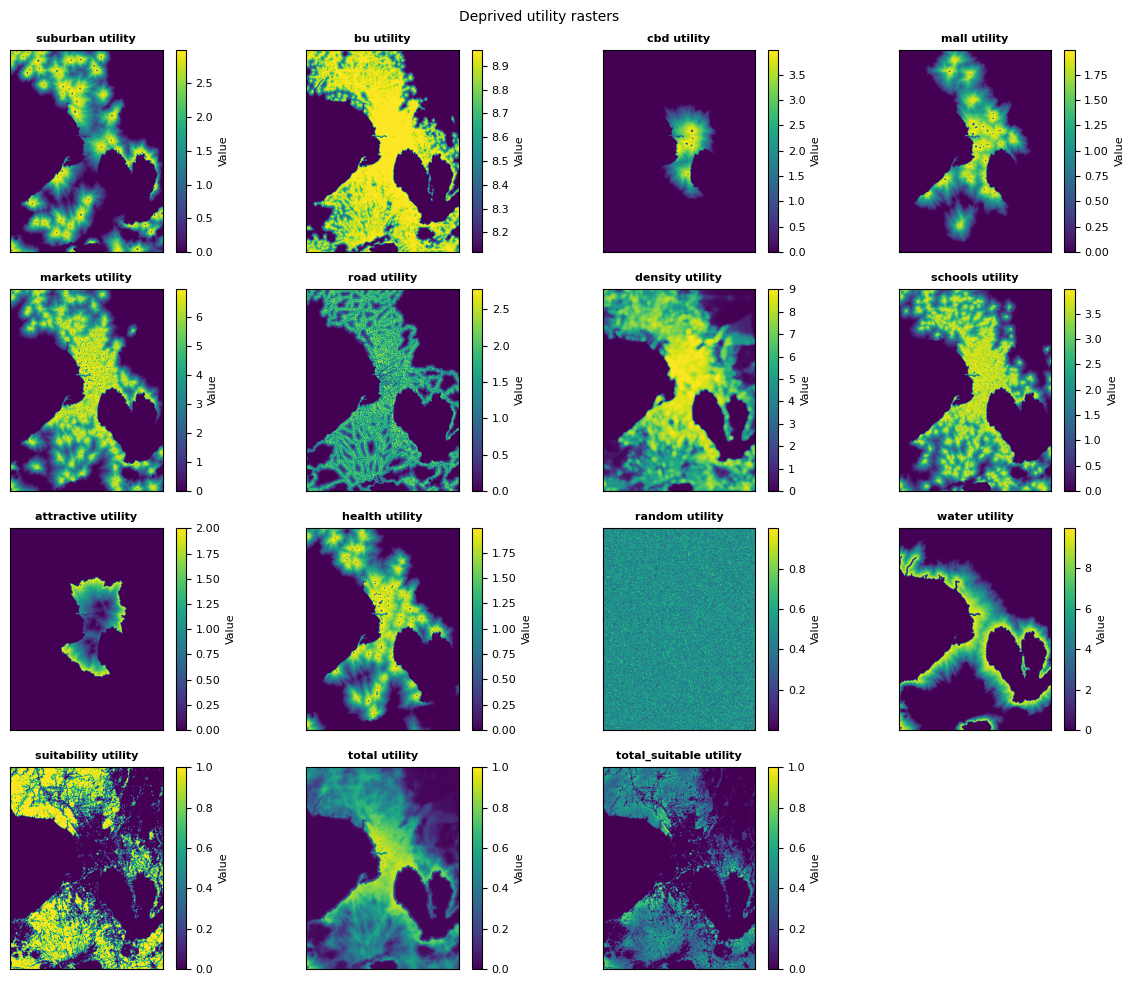

In [27]:
%run ./ti_city_00_raster_functions.ipynb
dp_utility_dict = calculate_utility(ut_raster_dict, dp_wt_dict, suitability_layer)
plot_many_rasters(dp_utility_dict, 'Deprived utility rasters',ref_raster_path = ref_raster_sleuth_path)

### LI Utility

Error calculating utility for [0 0]
Min value: 0.0 , Max value: 1.0


C:\Users\ra42zek\AppData\Local\Temp\ipykernel_21884\3402136396.py:43: RuntimeWarning: invalid value encountered in divide
  utility_dict['total_suitable'] = (utility_dict['total_suitable'] - np.nanmin(utility_dict['total_suitable'])) / (np.nanmax(utility_dict['total_suitable']) - np.nanmin(utility_dict['total']))


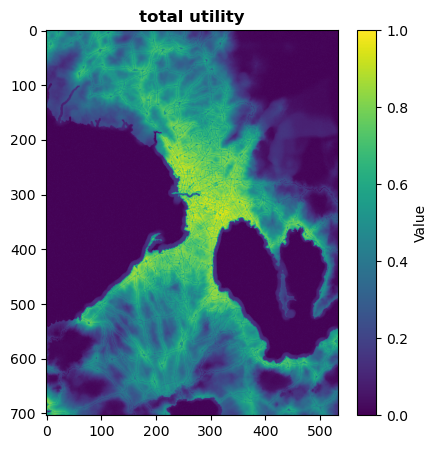

In [19]:
li_utility_dict = calculate_utility(ut_raster_dict, li_wt_dict)

# Display the utility array
#li_utility_dict
key = 'total'
plot_continuous_raster(li_utility_dict[key], key + ' utility')

### MI Utility

;;load mid income household utility for each patch / parcel
to load-UMI
  ask patches [
    set UMI (((1 - suburb) * miu-suburb) + (nom-neighbourhood * miu-neigbhour) +  ((1 - bu) * miu-bu) +
      ((1 - cbd) * miu-cbd) + ((1 - shoppingmall) * miu-mall) + ((1 - markets) * miu-markets) +
      ((1 - road) * miu-road) + (density * miu-density) + ((1 - schools) * miu-schools) +
      ((1 - attractive) * miu-attractive) + ((1 - healthfacilities) * miu-health) + ((random-float 0.1) * miu-random))
  ]
end

Error calculating utility for [0 0]


C:\Users\ra42zek\AppData\Local\Temp\ipykernel_21884\3402136396.py:43: RuntimeWarning: invalid value encountered in divide
  utility_dict['total_suitable'] = (utility_dict['total_suitable'] - np.nanmin(utility_dict['total_suitable'])) / (np.nanmax(utility_dict['total_suitable']) - np.nanmin(utility_dict['total']))


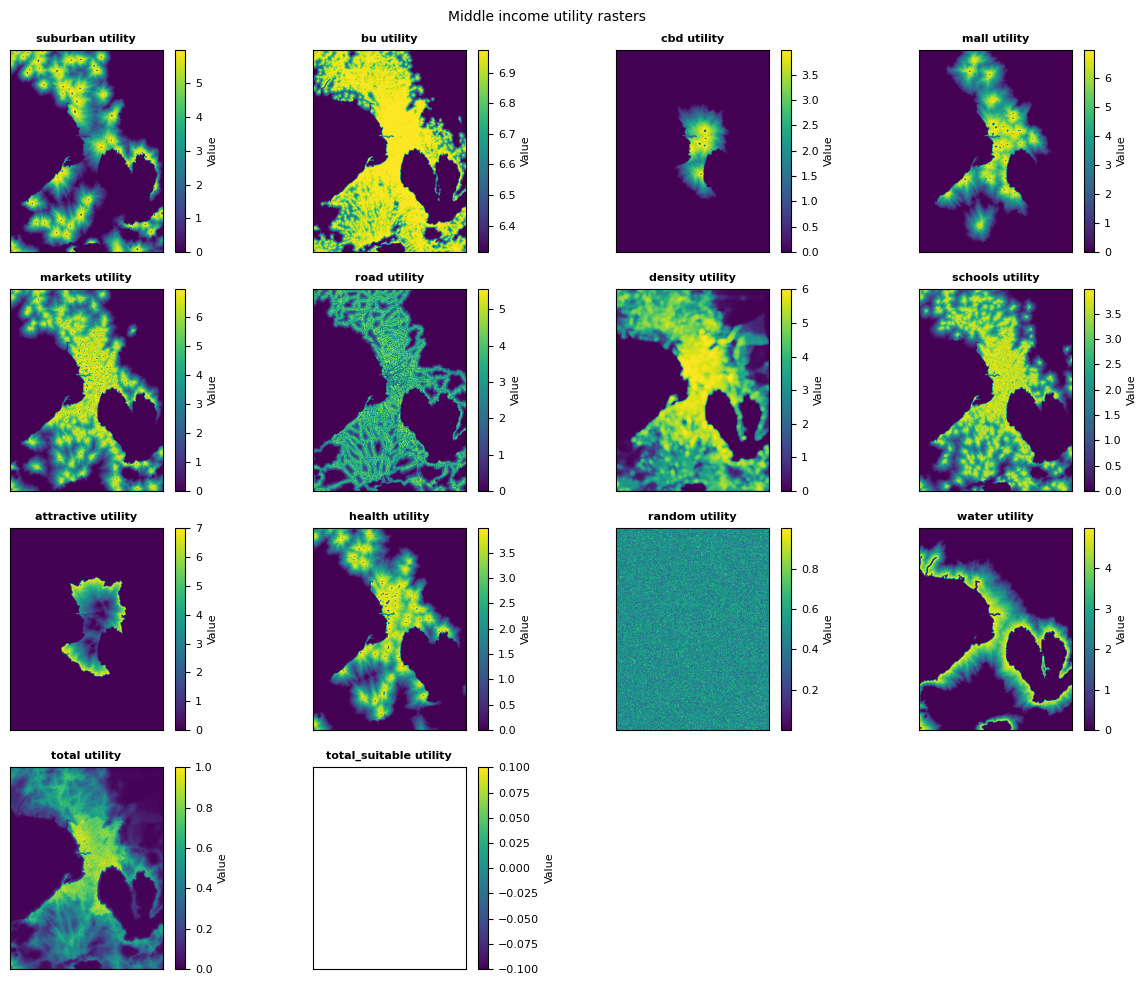

In [20]:
mi_utility_dict = calculate_utility(ut_raster_dict, mi_wt_dict)
plot_many_rasters(mi_utility_dict, 'Middle income utility rasters')


;; Development by middle income households
to make-mid-income-household-development
  let i household-number
  let n percent-mid-income-households
  let x ((i / simulation-period) * ( n / 100))
  let d patches with [(urban = 0) and (new-urban = 0) and (suitability = 1) and (landvalue < 3)]


  ask max-n-of (x * 3) d [UMI] [set first-n-UMI 1]

  ask n-of x households with [income-status = 2 and MIH-movement = 0] [

    move-to one-of patches with [(first-n-UMI = 1) and (MI-movement = 0)
        and (HI-movement = 0) and (LI-movement = 0) and (pMED-movement = 0) and (pHED-movement = 0)]

    ask patch-here
      [(set pcolor orange) (set MI-movement 1) (set new-urban 1)]
    set MIH-movement 1
    set color orange
    ]
end

### HI Uility

;;load high income household utility for each parcel
to load-UHI
  ask patches [
    set UHI (((1 - suburb) * hiu-suburb) + ((1 - nom-neighbourhood) * hiu-neigbhour) + ((1 - bu) * hiu-bu) +
      ((1 - cbd) * hiu-cbd) + ((1 - shoppingmall) * hiu-mall) + ((1 - markets) * hiu-markets) +
      ((1 - road) * hiu-road) + (density * hiu-density) + ((1 - schools) * hiu-schools) +
      ((1 - attractive) * hiu-attractive) + ((1 - healthfacilities) * hiu-health) + ((random-float 0.1) * hiu-random))
  ]
end

Error calculating utility for [0 0]


C:\Users\ra42zek\AppData\Local\Temp\ipykernel_21884\3402136396.py:43: RuntimeWarning: invalid value encountered in divide
  utility_dict['total_suitable'] = (utility_dict['total_suitable'] - np.nanmin(utility_dict['total_suitable'])) / (np.nanmax(utility_dict['total_suitable']) - np.nanmin(utility_dict['total']))


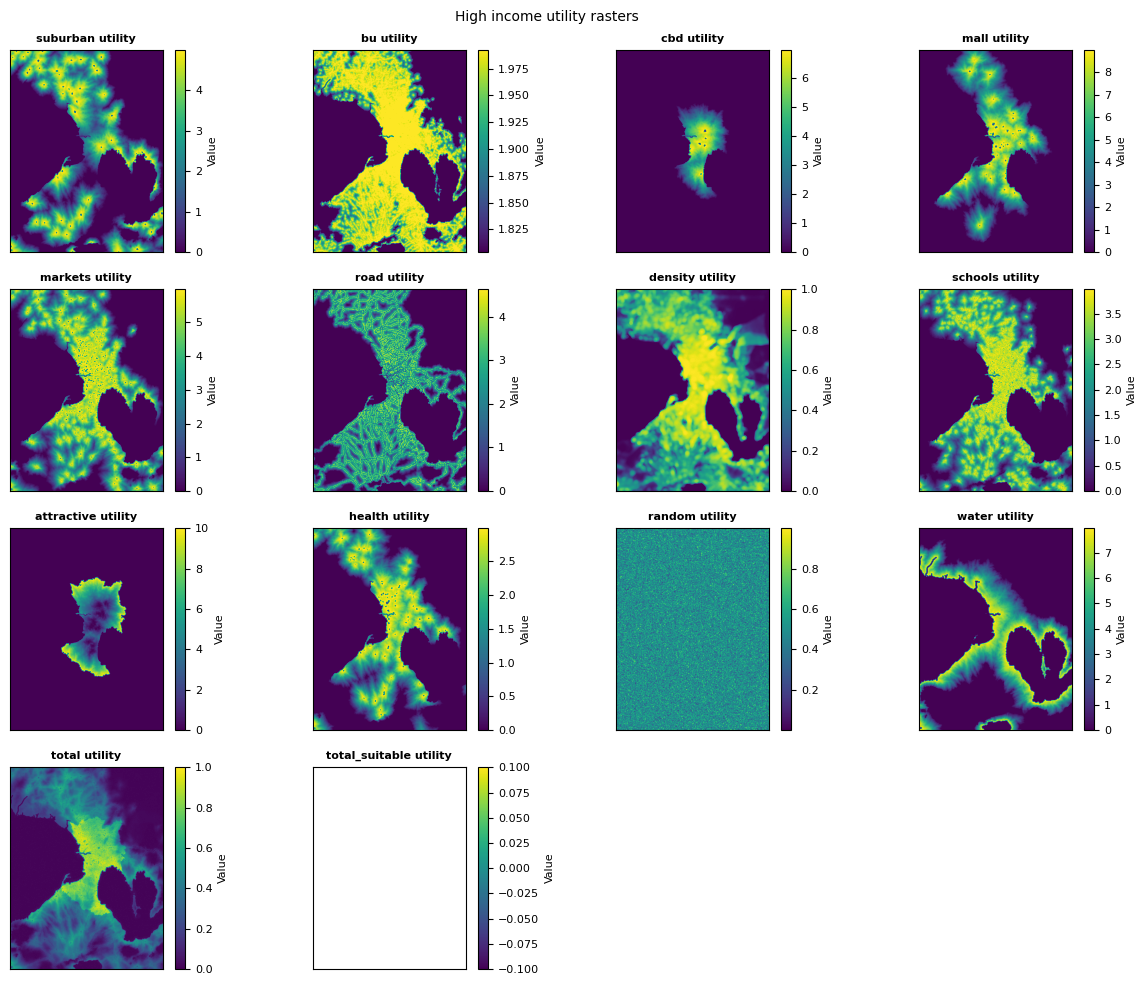

In [21]:
hi_utility_dict = calculate_utility(ut_raster_dict, hi_wt_dict)
plot_many_rasters(hi_utility_dict, 'High income utility rasters')

;;Make high income development
to make-high-income-household-development
  let i household-number
  let n percent-high-income-households
  let x ((i / simulation-period) * ( n / 100))
  let d patches with [(urban = 0) and (new-urban = 0) and (suitability = 1)]

  ask max-n-of (x * 3) d [UHI] [set first-n-UHI 1]


  ask n-of x households with [income-status = 3 and HIH-movement = 0] [
    move-to one-of patches with [(first-n-UHI = 1) and
        (HI-movement = 0) and (MI-movement = 0)and (LI-movement = 0) and (pMED-movement = 0) and (pHED-movement = 0)]

    ask patch-here [(set pcolor blue) (set HI-movement 1) (set new-urban 1)]
    set HIH-movement 1
    set color blue
  ]

end

### Compare utilities

In [11]:
# load urbanised areas
# generate a random raster from 0 to 1 with the dimensions of the slope raster
exclusion_file = ascii150_SLEUTH_path / 'MAN_lim_exclusion_layer_150m.asc'
urban_2000_file = ascii150_SLEUTH_path / 'MAN_URB_urbanisation_2000_EOC_WUF_150m.asc'
urban_2015_file = ascii150_SLEUTH_path / 'MAN_URB_urbanisation_2015_EOC_WUF_150m.asc'
urban_raster = urban_2015_file


with rasterio.open(exclusion_file) as src:
    exclusion_array = src.read(1)
    
with rasterio.open(urban_raster) as src:
    urban_array = src.read(1)


dp_utility_dict = calculate_utility(ut_raster_dict, dp_wt_dict)
li_utility_dict = calculate_utility(ut_raster_dict, li_wt_dict)
mi_utility_dict = calculate_utility(ut_raster_dict, mi_wt_dict)
hi_utility_dict = calculate_utility(ut_raster_dict, hi_wt_dict)

dp_utility_dict['total'] = dp_utility_dict['total'] - (urban_array + exclusion_array)
li_utility_dict['total'] = li_utility_dict['total'] - (urban_array + exclusion_array)
mi_utility_dict['total'] = mi_utility_dict['total'] - (urban_array + exclusion_array)
hi_utility_dict['total'] = hi_utility_dict['total'] - (urban_array + exclusion_array)

Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]


C:\Users\ra42zek\AppData\Local\Temp\ipykernel_21884\3402136396.py:43: RuntimeWarning: invalid value encountered in divide
  utility_dict['total_suitable'] = (utility_dict['total_suitable'] - np.nanmin(utility_dict['total_suitable'])) / (np.nanmax(utility_dict['total_suitable']) - np.nanmin(utility_dict['total']))


Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]


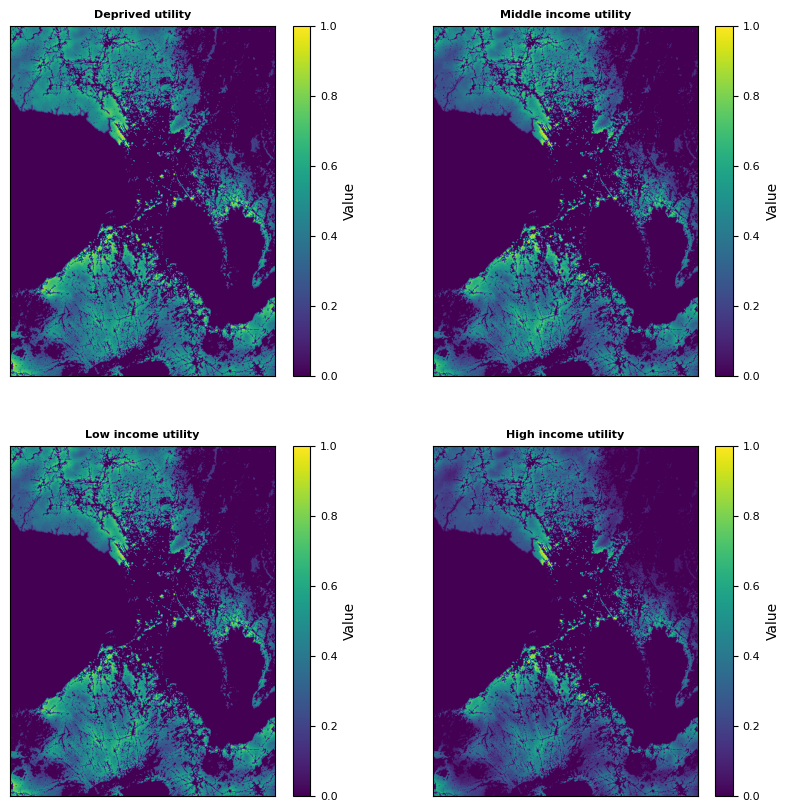

In [29]:
dp_utility_dict = calculate_utility(ut_raster_dict, dp_wt_dict,suitability_layer)
li_utility_dict = calculate_utility(ut_raster_dict, li_wt_dict,suitability_layer)
mi_utility_dict = calculate_utility(ut_raster_dict, mi_wt_dict,suitability_layer)
hi_utility_dict = calculate_utility(ut_raster_dict, hi_wt_dict,suitability_layer)

# plot the utility arrays for the different income groups
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 



def plot_array(array, title, ax):
    text_size = 8
    cmap = 'viridis'
    norm = mcolors.Normalize(vmin=np.min(array), vmax=np.max(array))
    show(array, ax=ax, cmap=cmap, norm=norm, title=title)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize=text_size)
    cbar.set_label('Value')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_size(text_size)

plot_array(dp_utility_dict['total_suitable'], 'Deprived utility', ax=ax[0,0])
plot_array(li_utility_dict['total_suitable'], 'Low income utility', ax=ax[1,0])
plot_array(mi_utility_dict['total_suitable'], 'Middle income utility', ax=ax[0,1])
plot_array(hi_utility_dict['total_suitable'], 'High income utility', ax=ax[1,1])


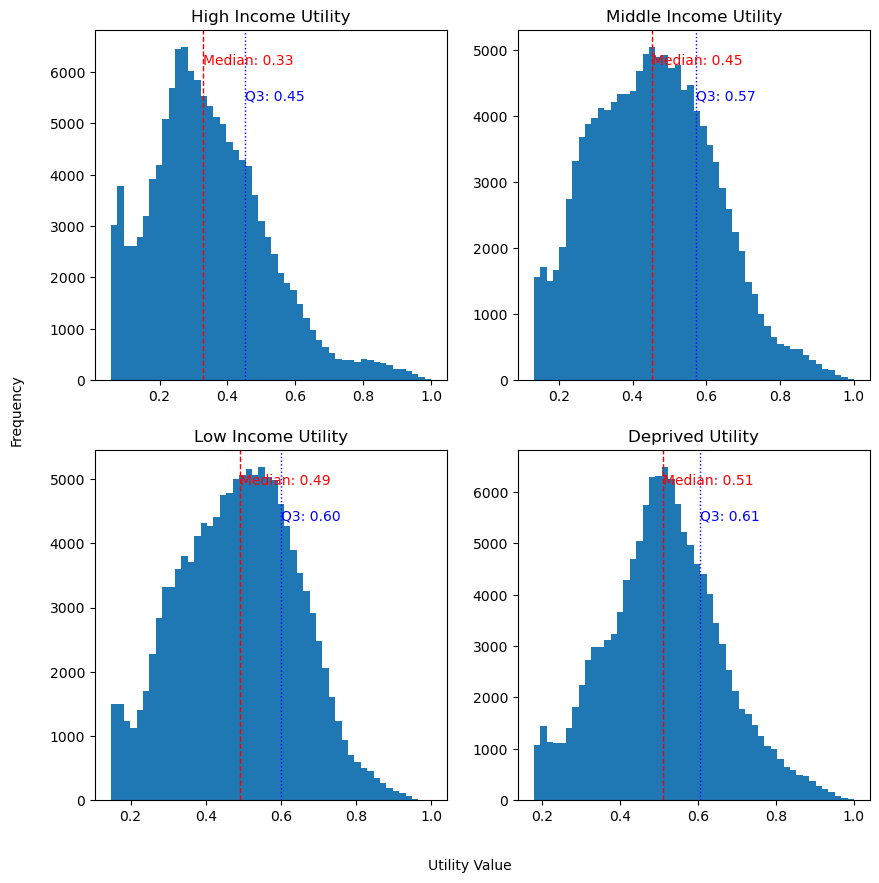

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
#plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 

ax[0,0].hist(hi_utility_dict['total_suitable'][hi_utility_dict['total_suitable'] > 0].flatten(), bins=50)
ax[0,1].hist(mi_utility_dict['total_suitable'][mi_utility_dict['total_suitable'] > 0].flatten(), bins=50)
ax[1,0].hist(li_utility_dict['total_suitable'][li_utility_dict['total_suitable'] > 0].flatten(), bins=50)
ax[1,1].hist(dp_utility_dict['total_suitable'][dp_utility_dict['total_suitable'] > 0].flatten(), bins=50)
ax[0,0].set_title('High Income Utility')
ax[0,1].set_title('Middle Income Utility')
ax[1,0].set_title('Low Income Utility')
ax[1,1].set_title('Deprived Utility')

# Add median and quartile 3 lines
for i, utility_dict in enumerate([hi_utility_dict, mi_utility_dict, li_utility_dict, dp_utility_dict]):
    median_value = np.median(utility_dict['total_suitable'][utility_dict['total_suitable'] > 0])
    q3_value = np.percentile(utility_dict['total_suitable'][utility_dict['total_suitable'] > 0], 75)
    ax[i//2, i%2].axvline(median_value, color='r', linestyle='dashed', linewidth=1)
    ax[i//2, i%2].axvline(q3_value, color='b', linestyle='dotted', linewidth=1)
    ax[i//2, i%2].text(median_value, ax[i//2, i%2].get_ylim()[1]*0.9, f'Median: {median_value:.2f}', color='r')
    ax[i//2, i%2].text(q3_value, ax[i//2, i%2].get_ylim()[1]*0.8, f'Q3: {q3_value:.2f}', color='b')

fig.text(0.5, 0.04, 'Utility Value', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')
plt.show()

### Test weights

Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]


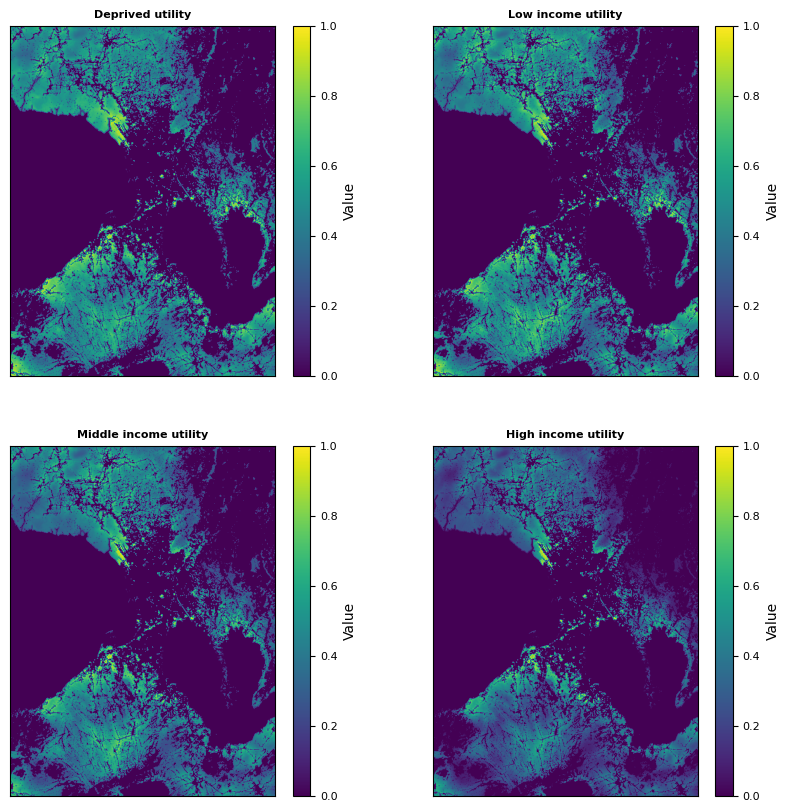

In [13]:
wt_file = 'MAN_ti_city_weights.xlsx'

def compare_utility(ut_raster_dict, wt_file, scenario, suitability_layer):
    # import the weight Excel file
    wt_df = pd.read_excel( ascii150_SLEUTH_path/ wt_file, sheet_name=scenario)

    # create a dictionary of the weights
    dp_wt_dict = dict(zip(ut_layers_list, wt_df.loc[wt_df['agent'] == 'dp', :].values[0][1:]))
    li_wt_dict = dict(zip(ut_layers_list, wt_df.loc[wt_df['agent'] == 'li', :].values[0][1:]))
    mi_wt_dict = dict(zip(ut_layers_list, wt_df.loc[wt_df['agent'] == 'mi', :].values[0][1:]))
    hi_wt_dict = dict(zip(ut_layers_list, wt_df.loc[wt_df['agent'] == 'hi', :].values[0][1:]))

    dp_utility_dict = calculate_utility(ut_raster_dict, dp_wt_dict, suitability_layer)
    li_utility_dict = calculate_utility(ut_raster_dict, li_wt_dict, suitability_layer)
    mi_utility_dict = calculate_utility(ut_raster_dict, mi_wt_dict, suitability_layer)
    hi_utility_dict = calculate_utility(ut_raster_dict, hi_wt_dict, suitability_layer)

    # plot the utility arrays for the different income groups
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
    plt.tick_params(left = False, right = False , labelleft = False , 
                        labelbottom = False, bottom = False) 

    plot_array(dp_utility_dict['total_suitable'], 'Deprived utility', ax=ax[0,0])
    plot_array(li_utility_dict['total_suitable'], 'Low income utility', ax=ax[0,1])
    plot_array(mi_utility_dict['total_suitable'], 'Middle income utility', ax=ax[1,0])
    plot_array(hi_utility_dict['total_suitable'], 'High income utility', ax=ax[1,1])


scenario='std'
suitability_layer = suitability_layer
ut_raster_dict = ut_raster_dict
compare_utility(ut_raster_dict, wt_file, scenario, suitability_layer)

Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]
Error calculating utility for [0 0]


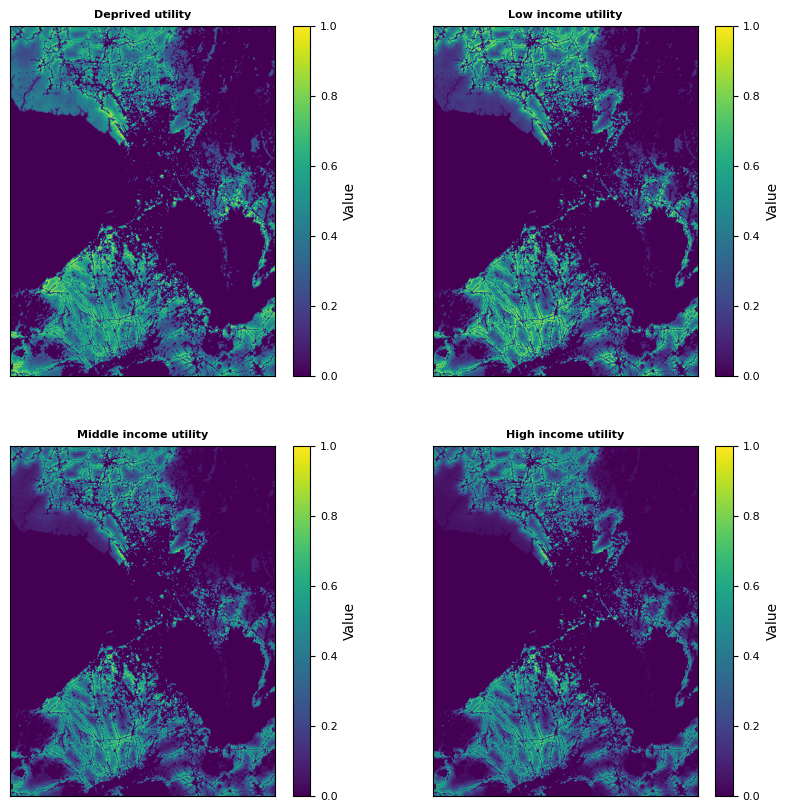

In [14]:
scenario='c22'
suitability_layer = suitability_layer
ut_raster_dict = ut_raster_dict
compare_utility(ut_raster_dict, wt_file, scenario, suitability_layer)

### Export utilities

#### total suitable

In [15]:
# export the utility arrays to a raster
raster_data_type=rasterio.float32
ref_raster_path=ref_raster_sleuth_path
raster_obj = dp_utility_dict['total_suitable']
dp_utility_path = interim_path / (case_city + '_URB_DP_utility_suitable_'+scenario+'_2015.tif')
export_raster(raster_obj,dp_utility_path,raster_data_type, ref_raster_path)

raster_obj = li_utility_dict['total_suitable']
li_utility_path = interim_path / (case_city + '_URB_LI_utility_suitable_'+scenario+'_2015.tif')
export_raster(raster_obj,li_utility_path,raster_data_type, ref_raster_path)

raster_obj = mi_utility_dict['total_suitable']
mi_utility_path = interim_path / (case_city + '_URB_MI_utility_suitable_'+scenario+'_2015.tif')
export_raster(raster_obj,mi_utility_path,raster_data_type, ref_raster_path)

raster_obj = hi_utility_dict['total_suitable']
hi_utility_path = interim_path / (case_city + '_URB_HI_utility_suitable_'+scenario+'_2015.tif')
export_raster(raster_obj,hi_utility_path,raster_data_type, ref_raster_path)


#### total

In [16]:
# export the utility arrays to a raster
raster_data_type=rasterio.float32
ref_raster_path=ref_raster_sleuth_path
raster_obj = dp_utility_dict['total']
dp_utility_path = interim_path / (case_city + '_URB_DP_utility_'+scenario+'_2015.tif')
export_raster(raster_obj,dp_utility_path,raster_data_type, ref_raster_path)

raster_obj = li_utility_dict['total']
li_utility_path = interim_path / (case_city + '_URB_LI_utility_'+scenario+'_2015.tif')
export_raster(raster_obj,li_utility_path,raster_data_type, ref_raster_path)

raster_obj = mi_utility_dict['total']
mi_utility_path = interim_path / (case_city + '_URB_MI_utility_'+scenario+'_2015.tif')
export_raster(raster_obj,mi_utility_path,raster_data_type, ref_raster_path)

raster_obj = hi_utility_dict['total']
hi_utility_path = interim_path / (case_city + '_URB_HI_utility_'+scenario+'_2015.tif')
export_raster(raster_obj,hi_utility_path,raster_data_type, ref_raster_path)



## roads

Min value: -1.0 , Max value: -0.0


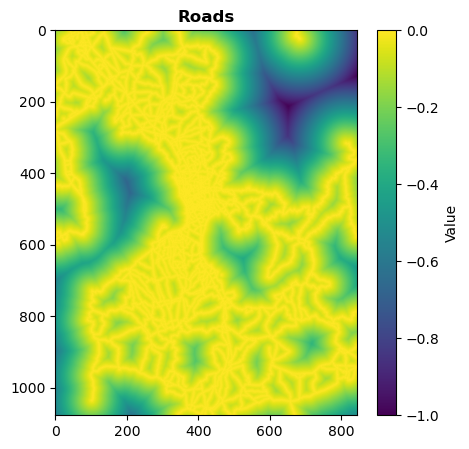

In [11]:
# testing a road proximity parameter

roads_raster_path = ti_city_ascii_path / 'roads.asc'
with rasterio.open(roads_raster_path) as src:
    roads_array = src.read(1)
    road_influence = np.where(roads_array > 0.3, 0, 1 - roads_array)
    road_influence = (road_influence - road_influence.min()) / (road_influence.max() - road_influence.min())
    plot_continuous_raster(-roads_array, 'Roads')

Min value: 0 , Max value: 1


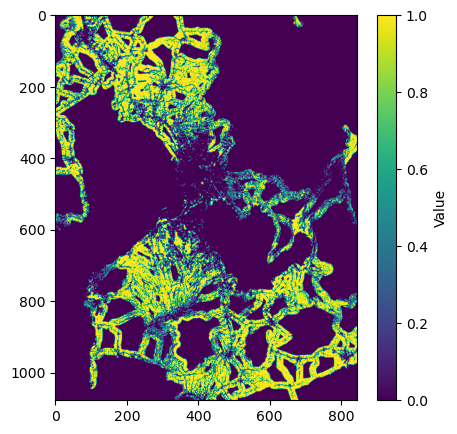

In [ ]:
# sharp cutoff from road attraction
suitability_array_roads = np.where(roads_array > 0.05, 0, suitability_array)

plot_continuous_raster(suitability_array_roads)

Min value: 0.0 , Max value: 1.0


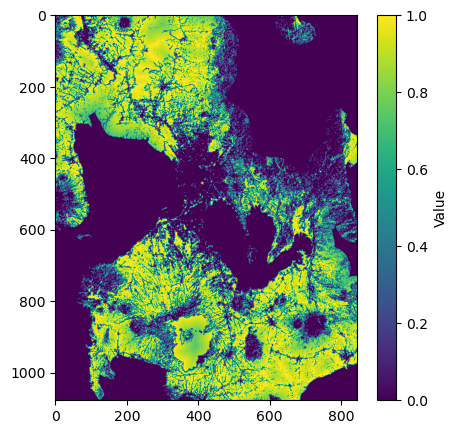

In [40]:
# gradient influence from road attraction
suitability_array_roads = suitability_array * road_influence

plot_continuous_raster(suitability_array_roads)

# The end (for now).